# Reproducing Figure 4 Brown et al. 2015

In [ ]:
import agama
import numpy as np
from astropy.coordinates import SkyCoord, Galactocentric
from astropy import units as u
from tqdm import tqdm
import os
import sys
import pandas as pd
from astropy.table import Table

# set current directory to /app/data so we can work with relative paths
os.chdir('/app/data/')
# Add the path to the 'scripts' folder directly
sys.path.append('/app/data/')

from scripts import orbit_integration_agama as oia


In [ ]:
import agama
agama.setUnits(mass=1, length=1, velocity=1)

# Loading the catalog of HVS candidates

This catalog contains both Gaia measurements and their HST based proper motion and radial velocity measurements

In [ ]:

# Load the star data
brown_data = pd.read_csv('Data/Brown_targets/brown_stars_gaia.csv')

# Load the same potential used in Brown et al. 2015

This potential is composed of 3 components, a Plummer sphere of $3.76 \times 10^9 M_{\odot}$ for the Bulge, a MiyamotoNagai disk with a scale radius of $2.75$ kpc, scale height of $0.3$ and a mass of $6 \times 10^{10} M_{\odot}$, the halo is modeled as a NFW potential with a scale radius of 20 kpc and a mass of $10^{11} M_{\odot}$

In [ ]:
potential = agama.Potential(file='Agama/brown2015.pot')  # Adjust file path if needed


# Compute plane crossing positions for all Brown stars using their HST measurements

In [ ]:
# compute orbits for all brown stars using HST proper motions, this should give the exact same contours as Figure 4 in the paper
plane_crossings = []
for i in range(len(brown_data)):
    star = brown_data.iloc[[i]]
    plane_crossings.append(oia.integrate_orbits_to_plane_crossing_agama_parallel(star, n_samples=10000,
                                                        integration_time=-0.5,  
                                                        pmra_col='mu_ra',
                                                        pmdec_col='mu_dec',
                                                        pmra_error_col='mu_ra_error',
                                                        pmdec_error_col='mu_dec_error', 
                                                        potential_file='Agama/brown2015.pot'))

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1158.11it/s]


## Plot the density level thresholds that contain 68.26 and 95.44% of all the crossings within them.

In [ ]:
# plotting function
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

def scatter_plot_origin(origins, xlim=(-60, 60), ylim=(-60, 60),
  bw_method='scott', save = False, star_name='star',
  save_path = 'Plots/brown_stars/scatterplots/brown_potential'
  ):
  """
    Plot the 1σ and 2σ contours of closest approach points in the X-Y plane.

    Parameters:
    - origins: list of tuples
      List of positions (X, Y, Z) at the closest approach for each sample.
    - xlim: tuple
      Limits for the X-axis (default: (-60, 60)).
    - ylim: tuple
      Limits for the Y-axis (default: (-60, 60)).
  """
  # Extract X, Y positions from origins
  x = np.array([origin[0] for origin in origins])
  y = np.array([origin[1] for origin in origins])

  plt.figure(figsize=(10, 10))
  
  plt.scatter(x, y, s=1)

  plt.scatter(0, 0, color='red', label='Galactic Center', s=100)  # Galactic Center

  # Add solar circles
  circle1 = plt.Circle((0, 0), 8.21, color='r', fill=False, lw=2, label='8.21 kpc')
  circle2 = plt.Circle((0, 0), 20, color='g', fill=False, linestyle='--', label='20 kpc')
  plt.gca().add_artist(circle1)
  plt.gca().add_artist(circle2)

  # Customize plot
  plt.xlabel('X [kpc]')
  plt.ylabel('Y [kpc]')
  plt.xlim(xlim)
  plt.ylim(ylim)
  plt.title(f'1σ and 2σ Contours of Closest Approach Points in X-Y Plane')
  plt.legend(loc='upper right')
  plt.grid(True)

    #plt.show()
  if save:
    if not os.path.exists(save_path):
      os.makedirs(save_path)
    plt.savefig(os.path.join(save_path, star_name+'.png'))


def plot_sigma_contours(origins, xlim=(-60, 60), ylim=(-60, 60), bw_method='scott', save = False, star_name='star', save_path = 'Plots/brown_stars/brown_potential'):
    """
    Plot the 1σ and 2σ contours of closest approach points in the X-Y plane.

    Parameters:
    - origins: list of tuples
      List of positions (X, Y, Z) at the closest approach for each sample.
    - xlim: tuple
      Limits for the X-axis (default: (-60, 60)).
    - ylim: tuple
      Limits for the Y-axis (default: (-60, 60)).
    """
    # Extract X, Y positions from origins
    x = np.array([origin[0] for origin in origins])
    y = np.array([origin[1] for origin in origins])

    # Create a 2D KDE
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy, bw_method=bw_method)
    xi, yi = np.linspace(xlim[0], xlim[1], 300), np.linspace(ylim[0], ylim[1], 300)
    xi, yi = np.meshgrid(xi, yi)
    zi = kde(np.vstack([xi.flatten(), yi.flatten()])).reshape(xi.shape)
    
    # Normalize the KDE to get cumulative probabilities
    zi_flat = zi.flatten()
    sorted_zi = np.sort(zi_flat)
    cumsum_zi = np.cumsum(sorted_zi) / np.sum(sorted_zi)

    # Determine contour levels for 1σ (68.26%) and 2σ (95.44%)
    level_1sigma = sorted_zi[np.searchsorted(cumsum_zi, 1 - 0.6826)]
    level_2sigma = sorted_zi[np.searchsorted(cumsum_zi, 1- 0.9544)]
        

    # Find mode of the distribution
    mode_index = np.argmax(zi_flat)
    mode_x, mode_y = xi.flatten()[mode_index], yi.flatten()[mode_index]

    # Plot the KDE with contour levels
    plt.figure(figsize=(10, 10))
    #plt.contourf(xi, yi, zi, levels=100, cmap="Blues")
    #plt.colorbar(label="Density")
    # check if the levels are increasing

    try:
      plt.contour(xi, yi, zi, levels=[level_2sigma, level_1sigma, zi.max()], colors=['k', 'k', 'k'], 
                  linewidths=[2, 2, 2], linestyles=['--', '-','-'], labels=['1σ', '2σ', '0'])
      plt.contourf(xi, yi, zi, levels=[level_2sigma, level_1sigma, zi.max()], colors=['cyan', 'magenta', 'blue'], alpha=0.5)
    
    except ValueError:
      print('ValueError')
      print(level_2sigma, level_1sigma, zi.max())
      scatter_plot_origin(origins, xlim, ylim, save, star_name, save_path)
      return


    # Add annotations
    plt.scatter(mode_x, mode_y, color='black', label='Mode of Distribution', s=100, marker='x')
    plt.scatter(0, 0, color='red', label='Galactic Center', s=100)  # Galactic Center

    # Add solar circles
    circle1 = plt.Circle((0, 0), 8.21, color='r', fill=False, lw=2, label='8.21 kpc')
    circle2 = plt.Circle((0, 0), 20, color='g', fill=False, linestyle='--', label='20 kpc')
    plt.gca().add_artist(circle1)
    plt.gca().add_artist(circle2)

    # Customize plot
    plt.xlabel('X [kpc]')
    plt.ylabel('Y [kpc]')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title('1σ and 2σ Contours of Closest Approach Points in X-Y Plane')
    plt.legend(loc='upper right')
    plt.grid(True)
    #plt.show()
    if save:
      os.makedirs(save_path, exist_ok=True)
      plt.savefig(os.path.join(save_path, star_name+'.png'))
    plt.show()


def plot_sigma_contours_m(origins, xlim=(-60, 60), ylim=(-60, 60), bw_method='scott',
 save = False, star_name='star', save_path = 'Plots/brown_stars/brown_potential'):
    """
    Plot the 1σ and 2σ contours of closest approach points in the X-Y plane.

    Parameters:
    - origins: list of tuples
      List of positions (X, Y, Z) at the closest approach for each sample.
    - xlim: tuple
      Limits for the X-axis (default: (-60, 60)).
    - ylim: tuple
      Limits for the Y-axis (default: (-60, 60)).
    """
    # Extract X, Y positions from origins
    x = np.array([origin[0] for origin in origins])
    y = np.array([origin[1] for origin in origins])

    # Create a 2D KDE
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy, bw_method=bw_method)
    xi, yi = np.linspace(xlim[0], xlim[1], 300), np.linspace(ylim[0], ylim[1], 300)
    xi, yi = np.meshgrid(xi, yi)
    zi = kde(np.vstack([xi.flatten(), yi.flatten()])).reshape(xi.shape)
    
    # Normalize the KDE to get cumulative probabilities
    zi_flat = zi.flatten()
    sorted_zi = np.sort(zi_flat)
    cumsum_zi = np.cumsum(sorted_zi) / np.sum(sorted_zi)

    # Determine contour levels for 1σ (68.26%) and 2σ (95.44%)
    level_1sigma = sorted_zi[np.searchsorted(cumsum_zi, 1 - 0.6826)]
    level_2sigma = sorted_zi[np.searchsorted(cumsum_zi, 1- 0.9544)]

    # Find mode of the distribution
    mode_index = np.argmax(zi_flat)
    mode_x, mode_y = xi.flatten()[mode_index], yi.flatten()[mode_index]

    # Plot the KDE with contour levels
    plt.figure(figsize=(10, 8))
    plt.contourf(xi, yi, zi, levels=100, cmap="Blues")
    plt.colorbar(label="Density")

    plt.contour(xi, yi, zi, levels=[level_2sigma, level_1sigma, zi.max()], colors=['red', 'darkorange', 'k'], 
                linewidths=[2, 2, 2], linestyles=['--', '-','-'])
    #plt.contourf(xi, yi, zi, levels=[level_2sigma, level_1sigma, zi.max()], colors=['cyan', 'magenta', 'blue'], alpha=0.5)
    
    # Add annotations
    plt.scatter(mode_x, mode_y, color='black', label='Mode of Distribution', s=100, marker='x')
    plt.scatter(0, 0, color='red', label='Galactic Center', s=100)  # Galactic Center

    # Add solar circles
    circle1 = plt.Circle((0, 0), 8.21, color='r', fill=False, lw=2, label='8.21 kpc')
    circle2 = plt.Circle((0, 0), 20, color='g', fill=False, linestyle='--', label='20 kpc')
    plt.gca().add_artist(circle1)
    plt.gca().add_artist(circle2)

    # Customize plot
    plt.xlabel('X [kpc]')
    plt.ylabel('Y [kpc]')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title(f'1σ and 2σ Contours of Closest Approach Points in X-Y Plane \n Probability of GC origin {prob_00:.2e}')
    plt.legend(loc='upper right')
    plt.grid(True)
    #plt.show()
    if save:
      if not os.path.exists(save_path):
        os.makedirs(save_path)
      plt.savefig(os.path.join(save_path, star_name+'.png'))




In [ ]:
# testing other plotting function
def scatter_plot_origin(origins, xlim=(-60, 60), ylim=(-60, 60),
                        save=False, star_name='star',
                        save_path='Plots/brown_stars/scatterplots/brown_potential'):
    """
    Fallback: Scatter plot of X-Y positions of the closest approach.

    Parameters:
    - origins: list of tuples
      List of positions (X, Y, Z) at the closest approach for each sample.
    - xlim: tuple
      Limits for the X-axis (default: (-60, 60)).
    - ylim: tuple
      Limits for the Y-axis (default: (-60, 60)).
    """
    # Extract X, Y positions from origins
    x = np.array([origin[0] for origin in origins])
    y = np.array([origin[1] for origin in origins])

    plt.figure(figsize=(10, 10))
    plt.scatter(x, y, s=1, label='Samples')

    plt.scatter(0, 0, color='red', label='Galactic Center', s=100)  # Galactic Center

    # Add solar circles
    circle1 = plt.Circle((0, 0), 8.21, color='r', fill=False, lw=2, label='8.21 kpc')
    circle2 = plt.Circle((0, 0), 20, color='g', fill=False, linestyle='--', label='20 kpc')
    plt.gca().add_artist(circle1)
    plt.gca().add_artist(circle2)

    # Customize plot
    plt.xlabel('X [kpc]')
    plt.ylabel('Y [kpc]')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title('Scatter Plot of Closest Approach Points in X-Y Plane')
    plt.legend(loc='upper right')
    plt.grid(True)

    if save:
        os.makedirs(save_path, exist_ok=True)
        plt.savefig(os.path.join(save_path, f"{star_name}.png"))

    plt.show()


def plot_sigma_contours(origins, xlim=(-60, 60), ylim=(-60, 60),
                        bw_method='scott', save=False, star_name='star',
                        save_path='Plots/brown_stars/brown_potential'):
    """
    Plot the 1σ and 2σ contours or fallback to scatter plot if KDE fails.

    Parameters:
    - origins: list of tuples
      List of positions (X, Y, Z) at the closest approach for each sample.
    - xlim: tuple
      Limits for the X-axis (default: (-60, 60)).
    - ylim: tuple
      Limits for the Y-axis (default: (-60, 60)).
    """
    # Extract X, Y positions from origins
    x = np.array([origin[0] for origin in origins])
    y = np.array([origin[1] for origin in origins])

    # Create a 2D KDE
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy, bw_method=bw_method)

    xi, yi = np.linspace(xlim[0], xlim[1], 300), np.linspace(ylim[0], ylim[1], 300)
    xi, yi = np.meshgrid(xi, yi)
    zi = kde(np.vstack([xi.flatten(), yi.flatten()])).reshape(xi.shape)

    try:
        # Normalize the KDE to get cumulative probabilities
        zi_flat = zi.flatten()
        sorted_zi = np.sort(zi_flat)
        cumsum_zi = np.cumsum(sorted_zi) / np.sum(sorted_zi)

        # Determine contour levels for 1σ (68.26%) and 2σ (95.44%)
        level_1sigma = sorted_zi[np.searchsorted(cumsum_zi, 1 - 0.6826)]
        level_2sigma = sorted_zi[np.searchsorted(cumsum_zi, 1 - 0.9544)]

        # Find mode of the distribution
        mode_index = np.argmax(zi_flat)
        mode_x, mode_y = xi.flatten()[mode_index], yi.flatten()[mode_index]

        # Plot the KDE with contour levels
        plt.figure(figsize=(10, 10))
        plt.contour(xi, yi, zi, levels=[level_2sigma, level_1sigma], colors=['k', 'k'], 
                    linewidths=[2, 2], linestyles=['--', '-'])
        plt.contourf(xi, yi, zi, levels=[level_2sigma, level_1sigma, zi.max()],
                     colors=['cyan', 'magenta', 'blue'], alpha=0.5)

        # Add annotations
        plt.scatter(mode_x, mode_y, color='black', label='Mode of Distribution', s=100, marker='x')
        plt.scatter(0, 0, color='red', label='Galactic Center', s=100)  # Galactic Center

        # Add solar circles
        circle1 = plt.Circle((0, 0), 8.21, color='r', fill=False, lw=2, label='8.21 kpc')
        circle2 = plt.Circle((0, 0), 20, color='g', fill=False, linestyle='--', label='20 kpc')
        plt.gca().add_artist(circle1)
        plt.gca().add_artist(circle2)

        # Customize plot
        plt.xlabel('X [kpc]')
        plt.ylabel('Y [kpc]')
        plt.xlim(xlim)
        plt.ylim(ylim)
        plt.title('1σ and 2σ Contours of Closest Approach Points in X-Y Plane')
        plt.legend(loc='upper right')
        plt.grid(True)

        if save:
            os.makedirs(save_path, exist_ok=True)
            plt.savefig(os.path.join(save_path, f"{star_name}.png"))

        plt.show()

    except ValueError as e:
        print(f"ValueError during contour plotting: {e}")
        scatter_plot_origin(origins, xlim, ylim, save, star_name, save_path)


In [ ]:
# remove NoneType tuples from plane_crossings
#plane_crossings = [x for x in plane_crossings if x is not None]

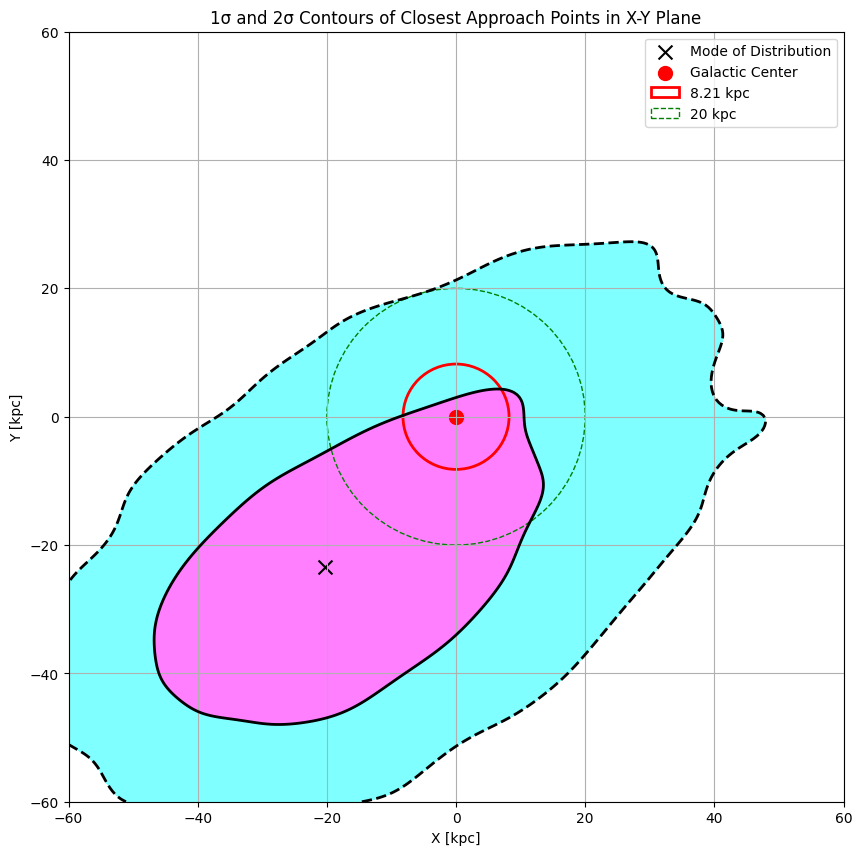

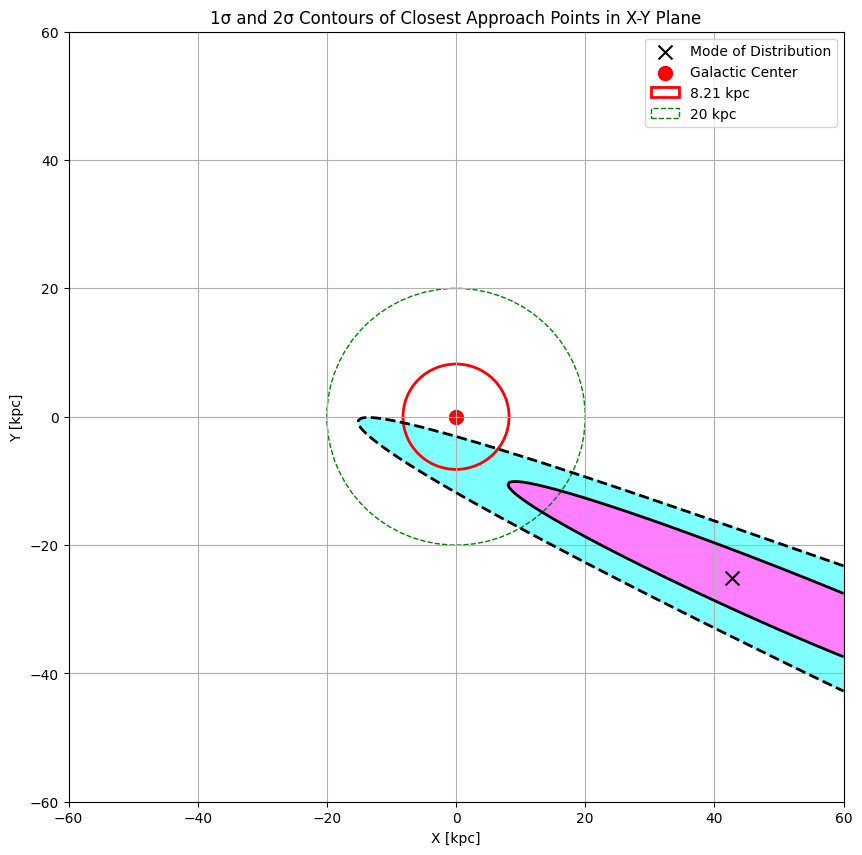

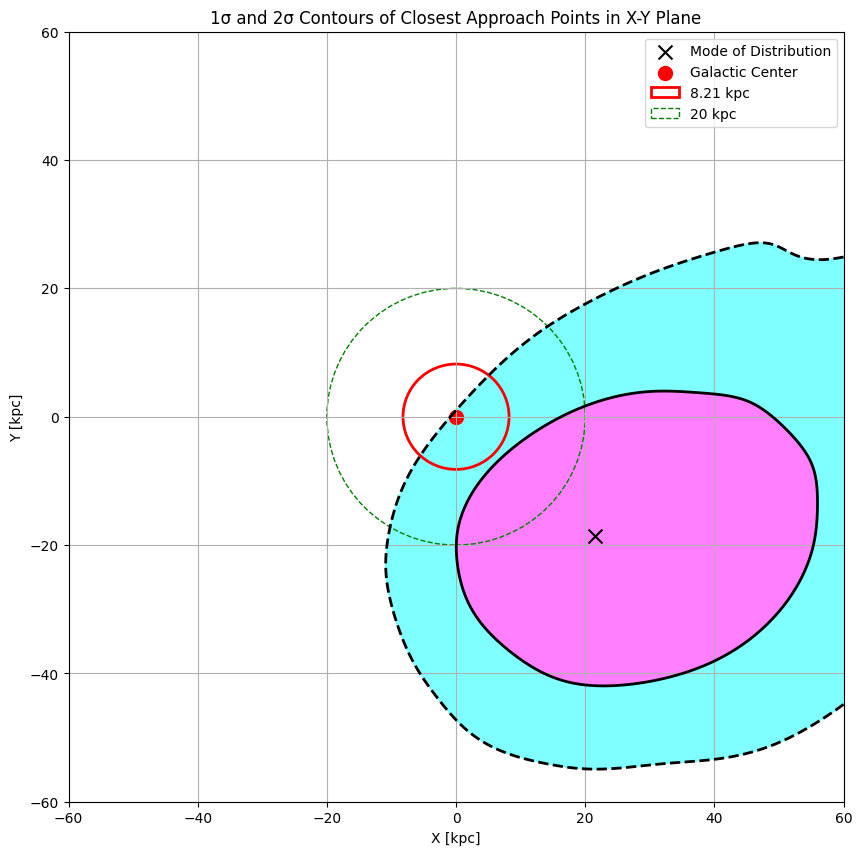

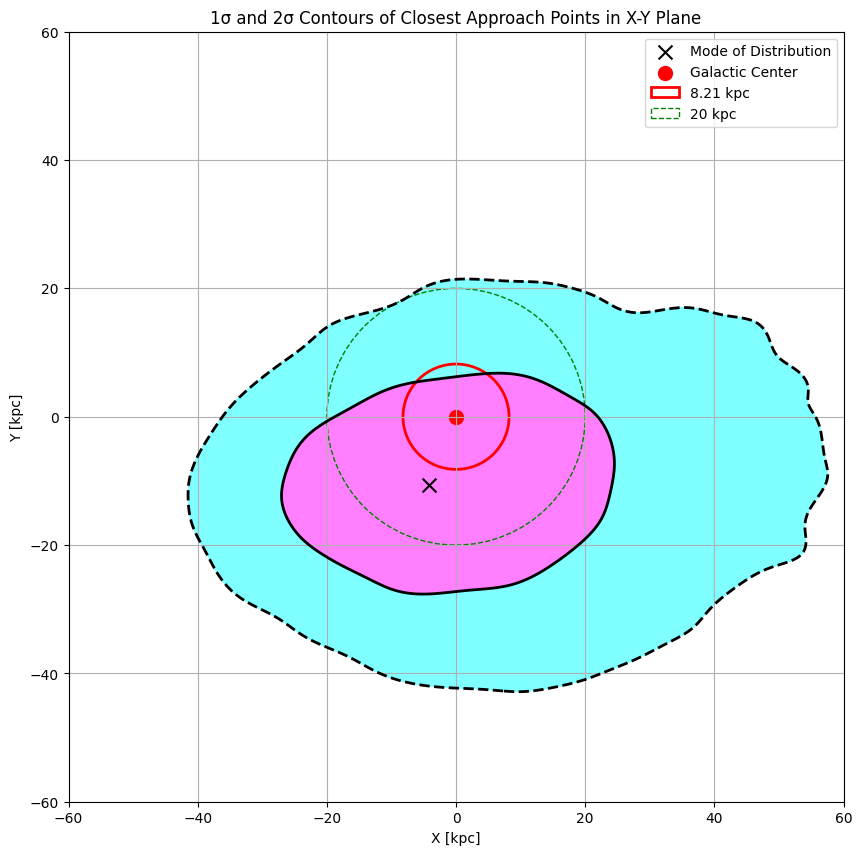

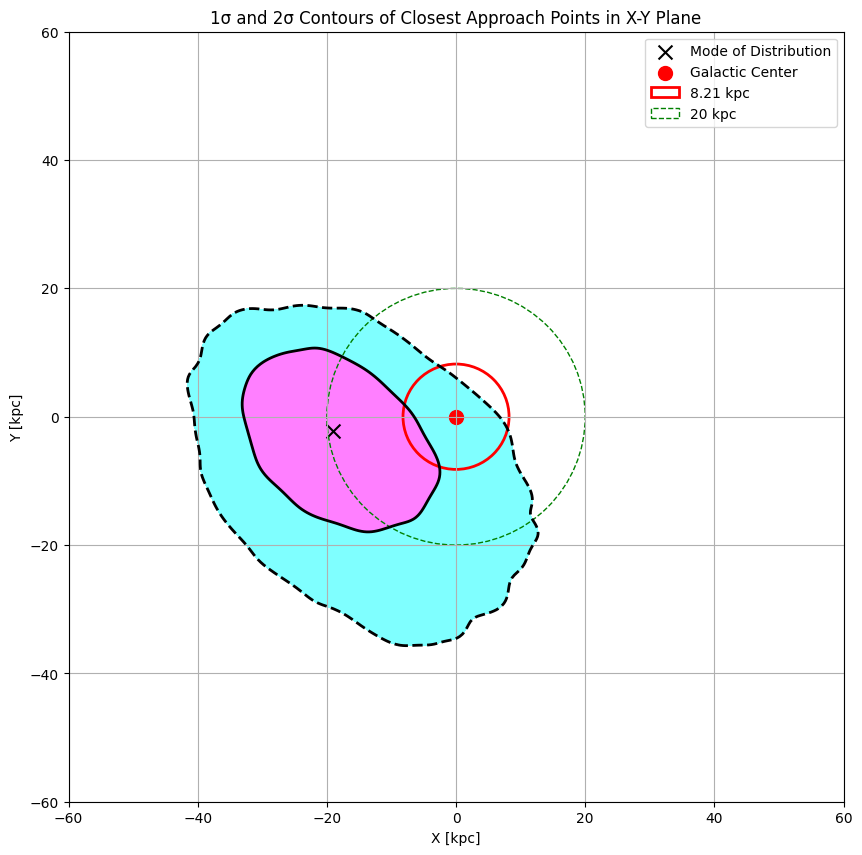

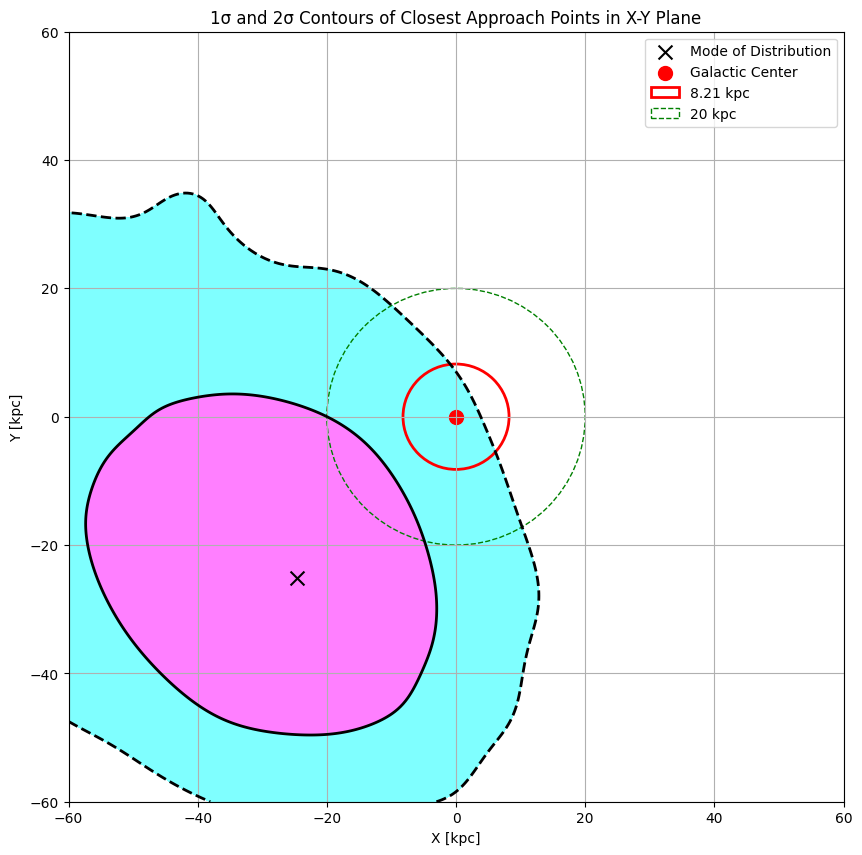

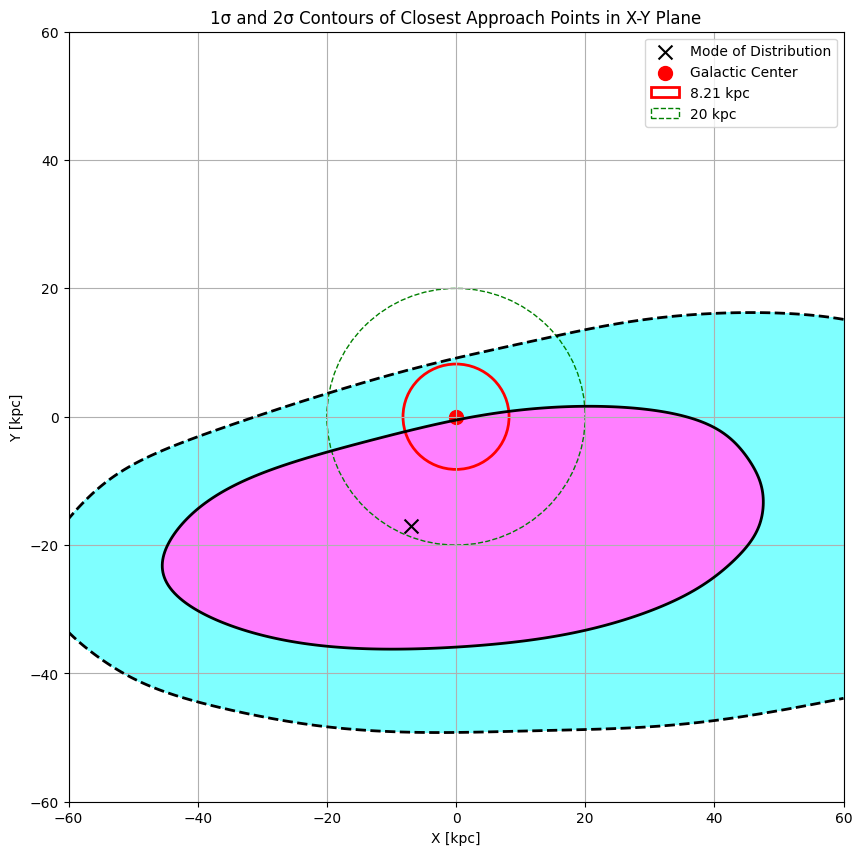

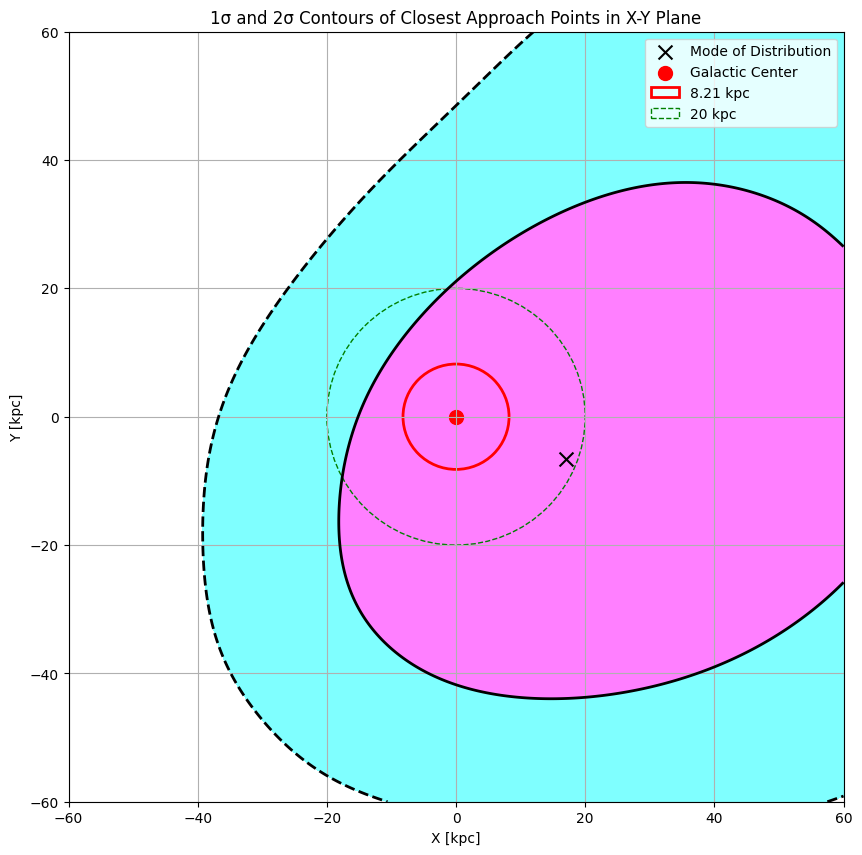

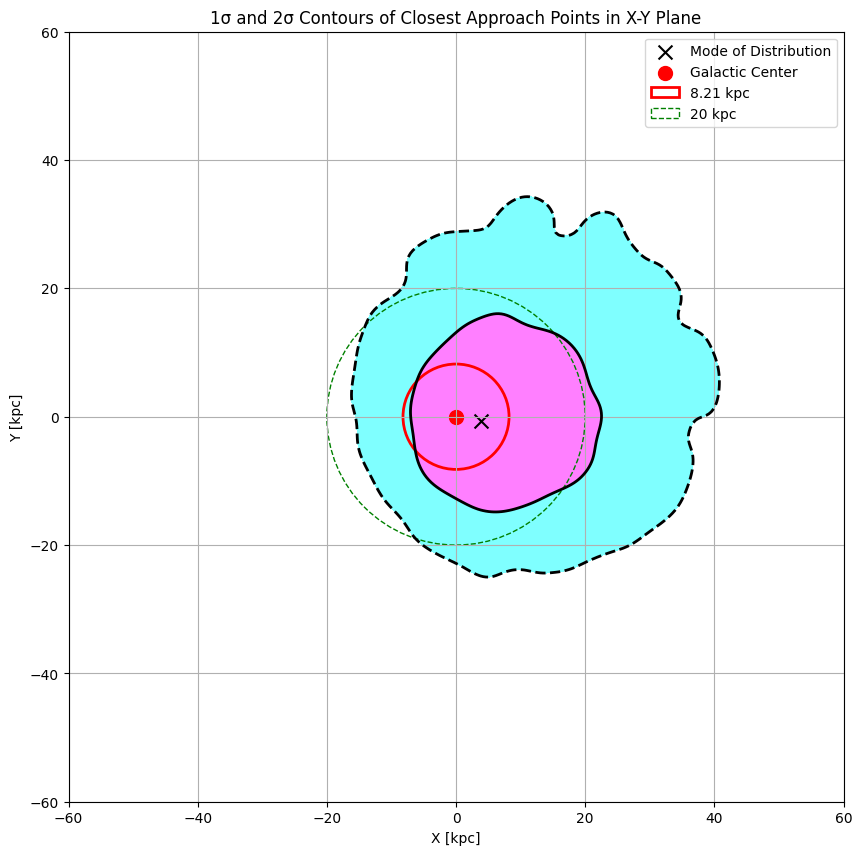

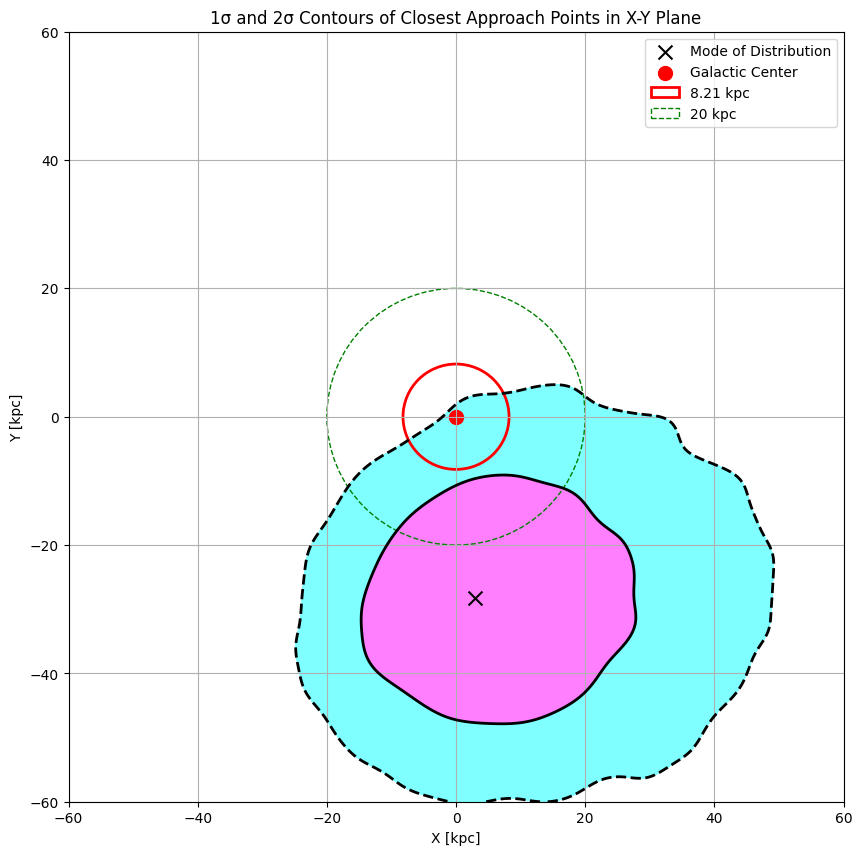

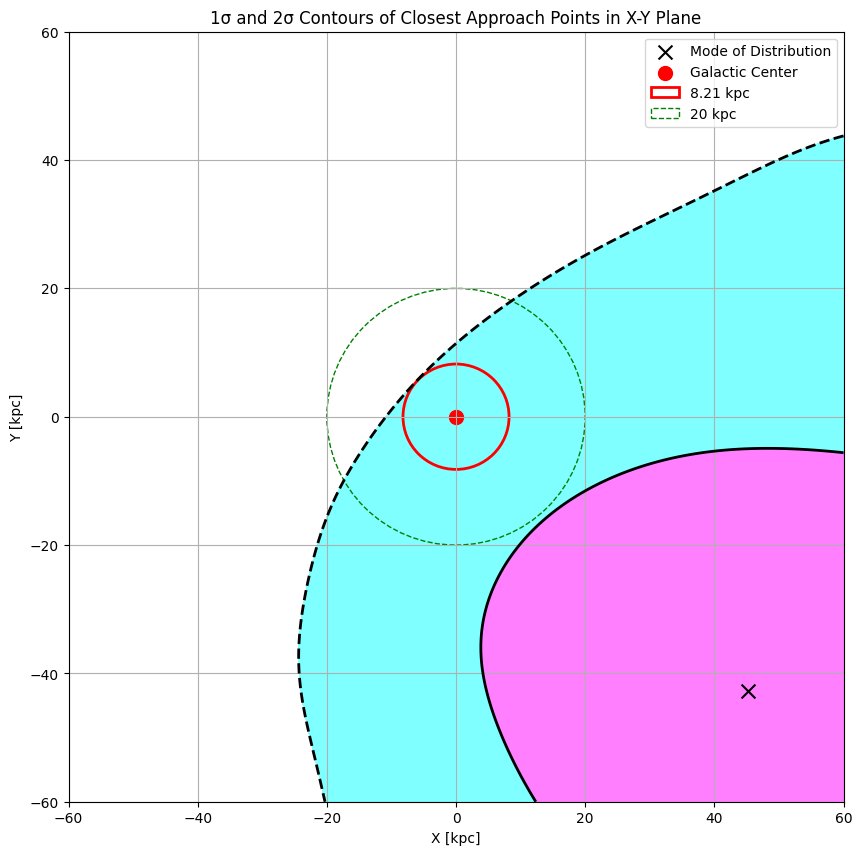

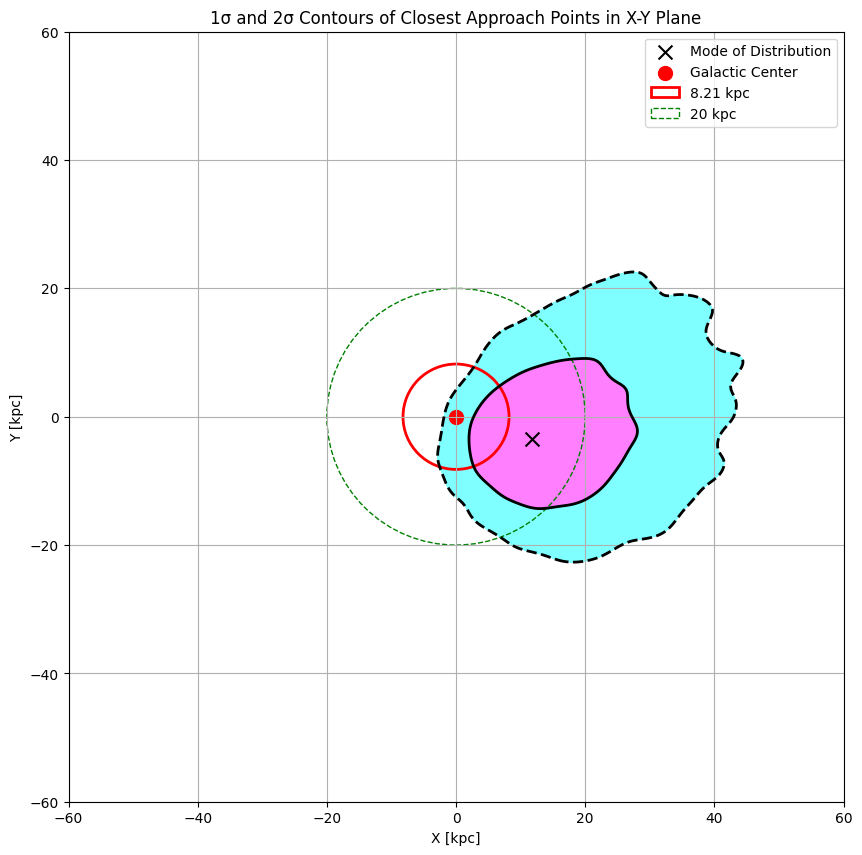

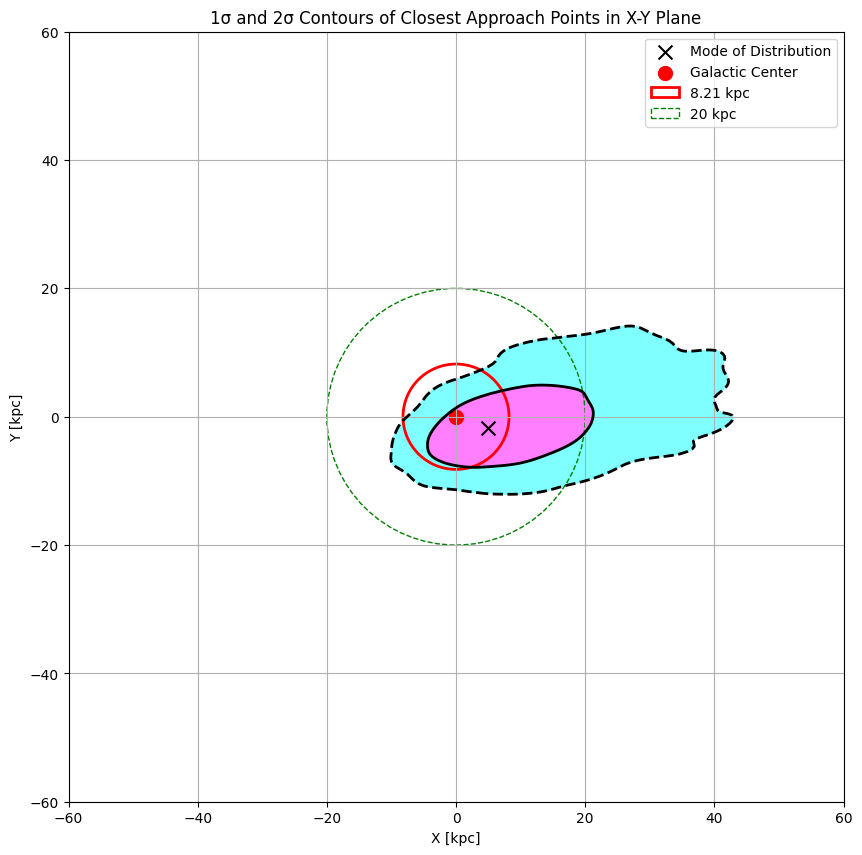

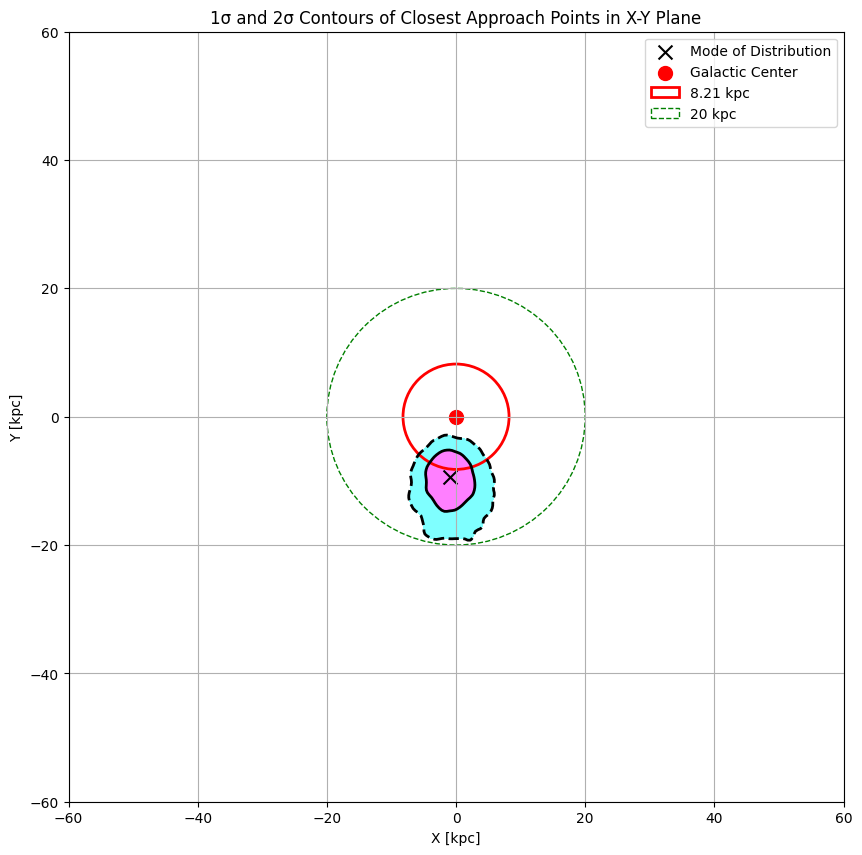

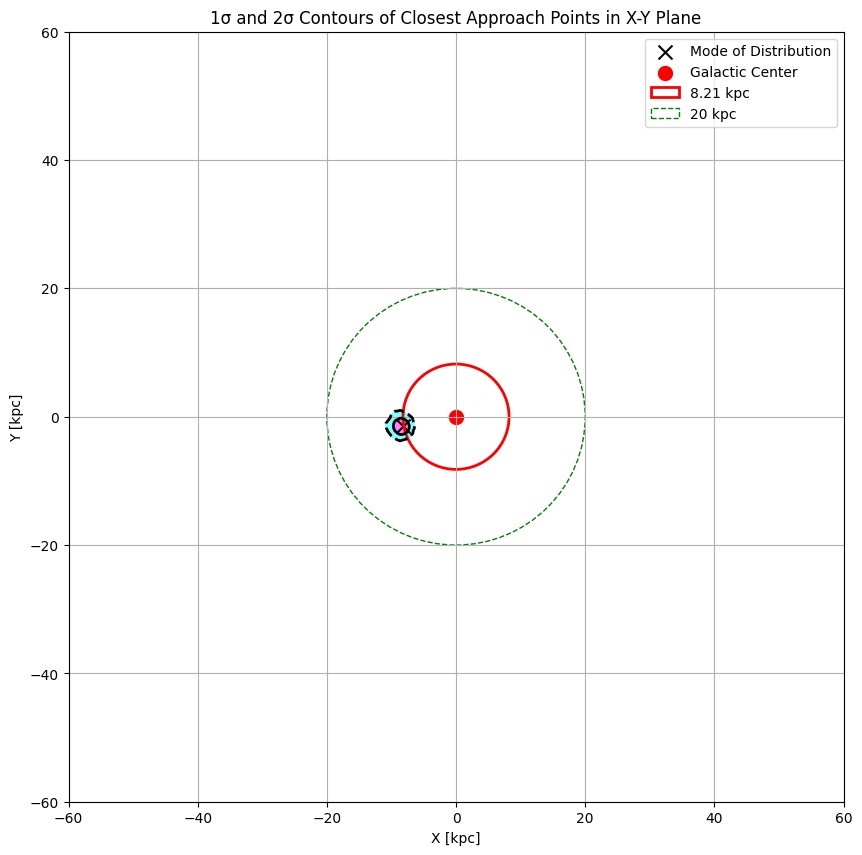

In [ ]:
for i in range(len(brown_data)):
    oia.plot_sigma_contours(plane_crossings[i], star_name=brown_data.iloc[[i]].ID.values[0], save=True)

# Compute plane crossing positions for all Brown stars using Gaia DR3 meaasurements

In [ ]:
# compute orbits for all brown stars using HST proper motions, this should give the exact same contours as Figure 4 in the paper
plane_crossings = []
for i in range(len(brown_data)):
    star = brown_data.iloc[[i]]
    plane_crossings.append(oia.integrate_orbits_to_plane_crossing_agama_parallel(star, n_samples=10000,
                                                        integration_time=-0.3,  
                                                        pmra_col='pmra',
                                                        pmdec_col='pmdec',
                                                        pmra_error_col='pmra_error',
                                                        pmdec_error_col='pmdec_error', 
                                                        potential_file='Agama/brown2015.pot'))

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1301.45it/s]


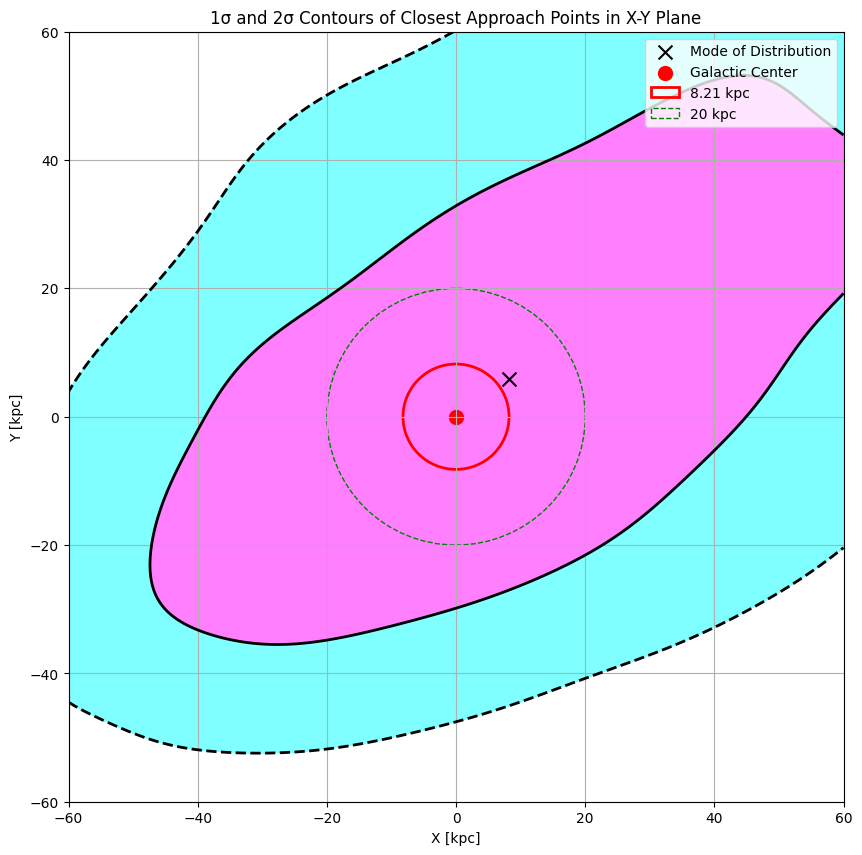

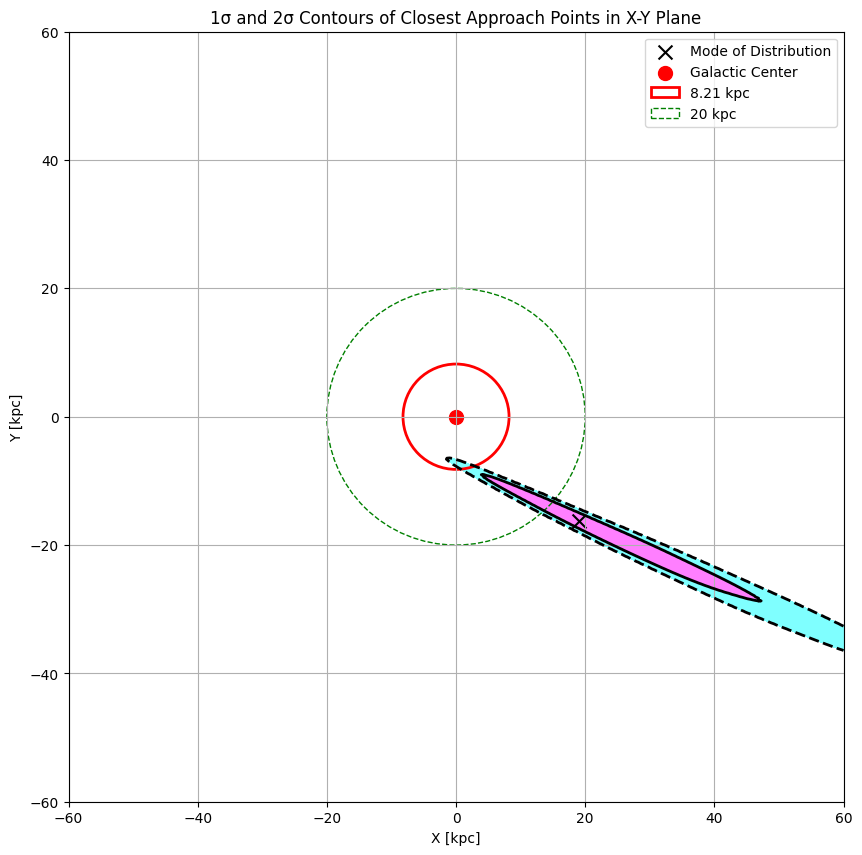

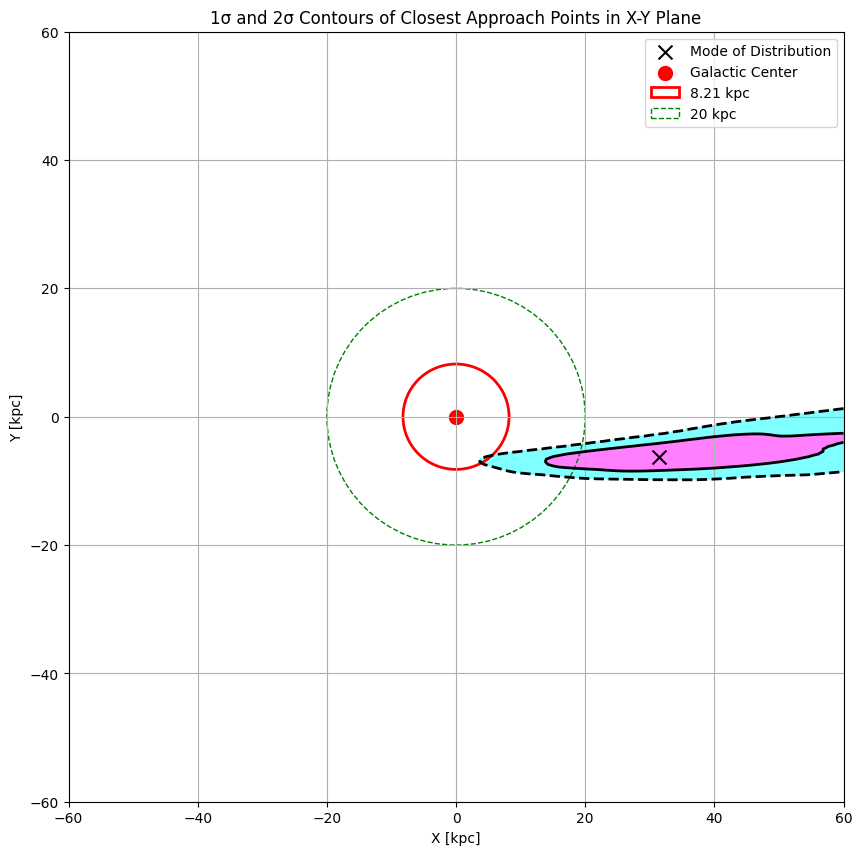

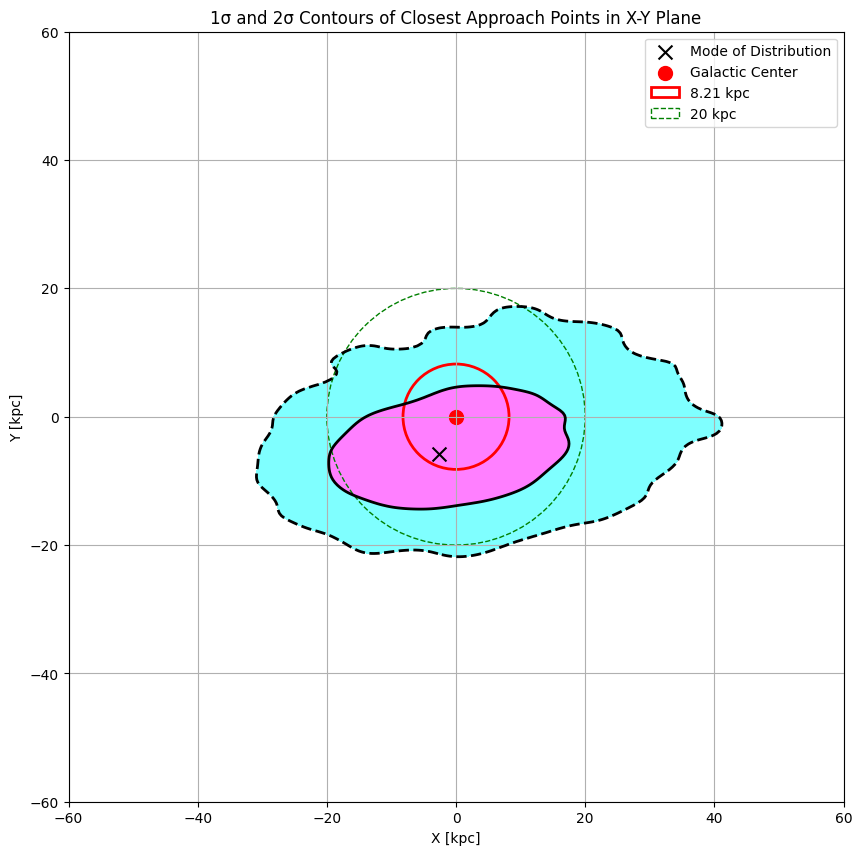

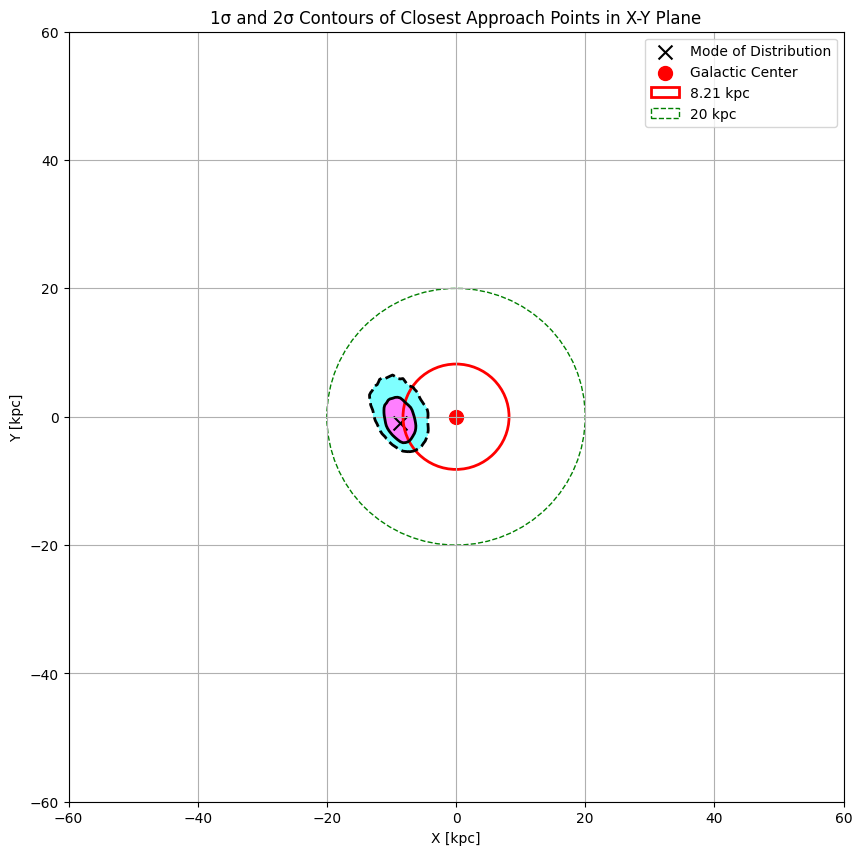

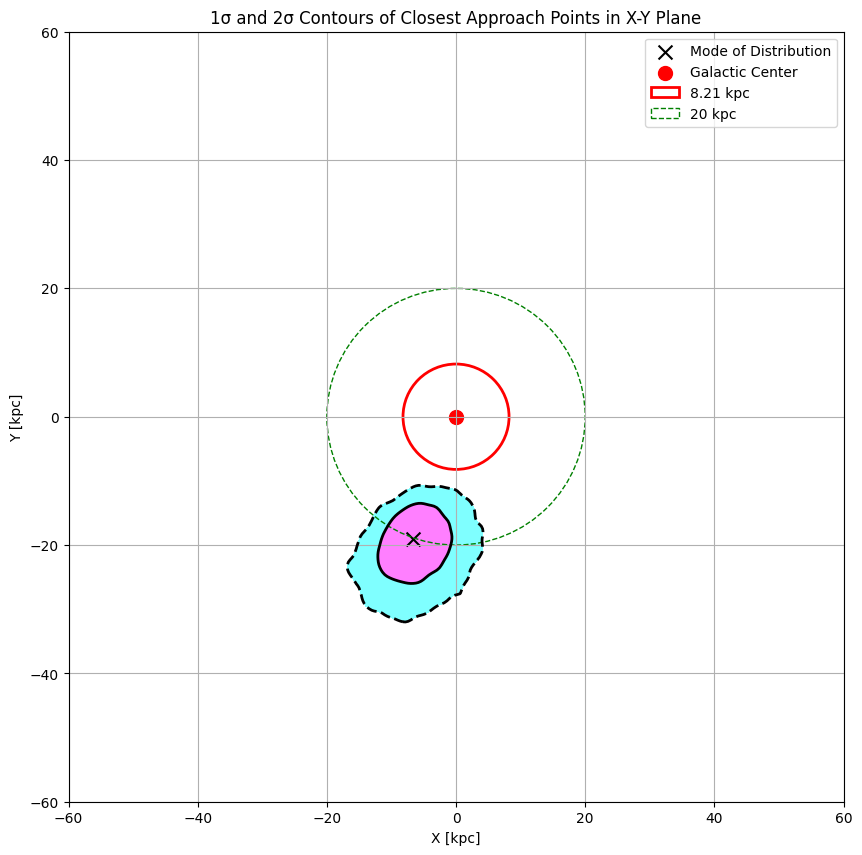

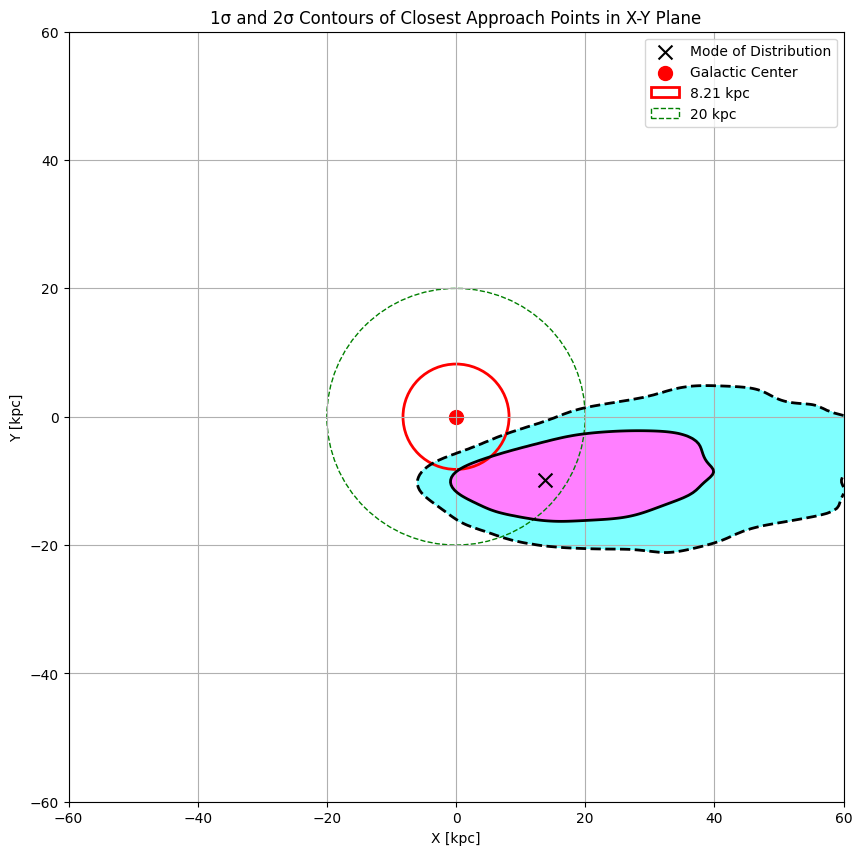

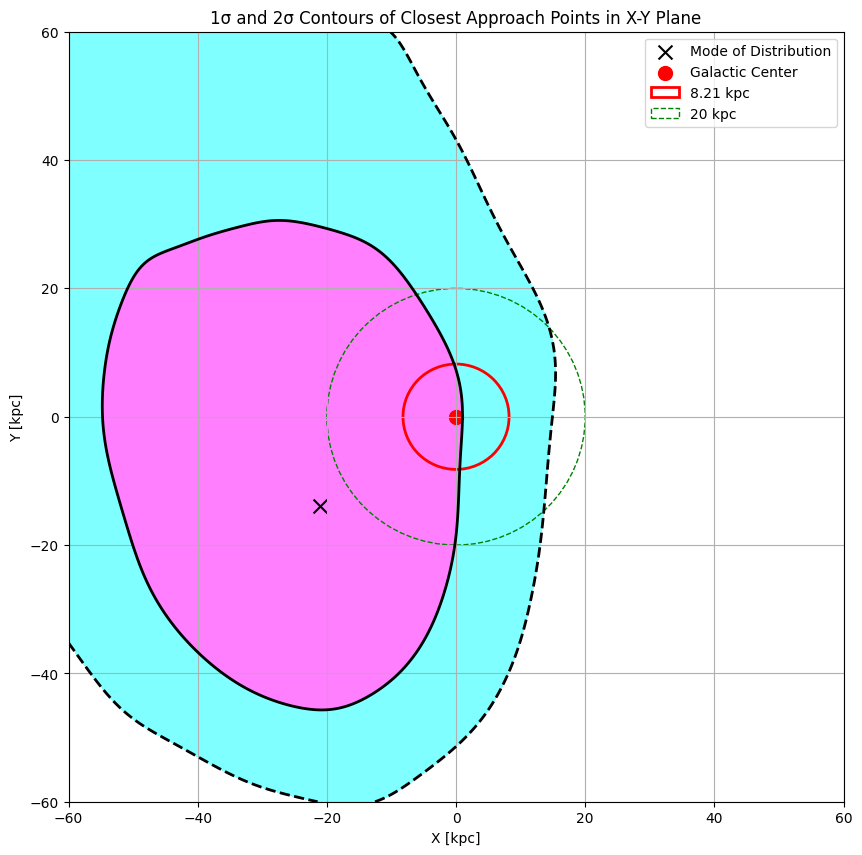

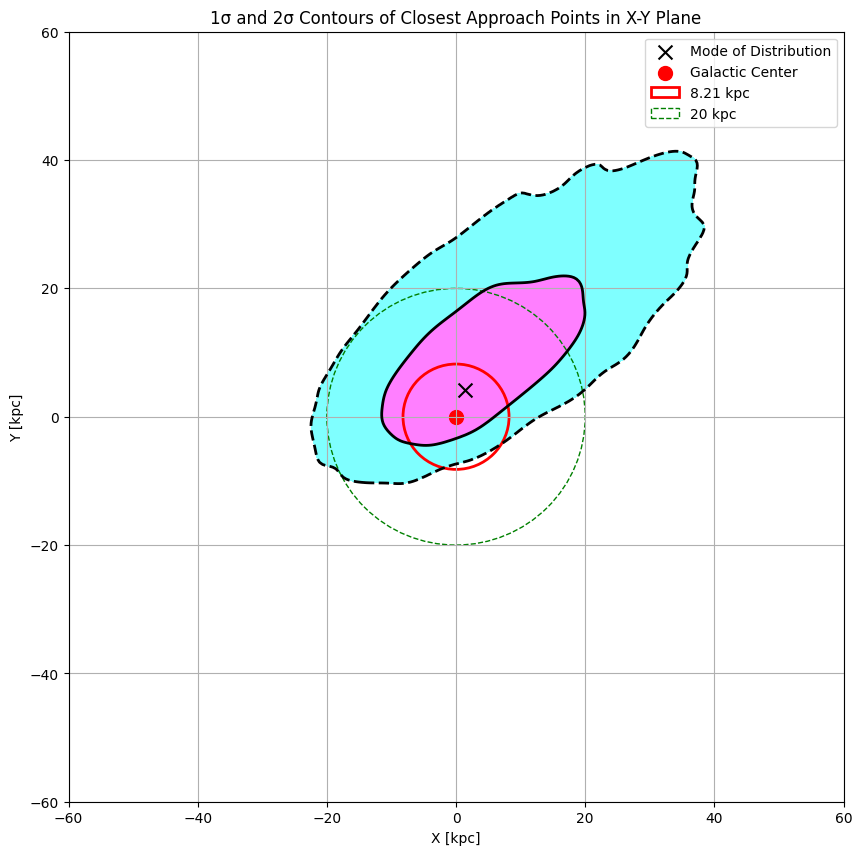

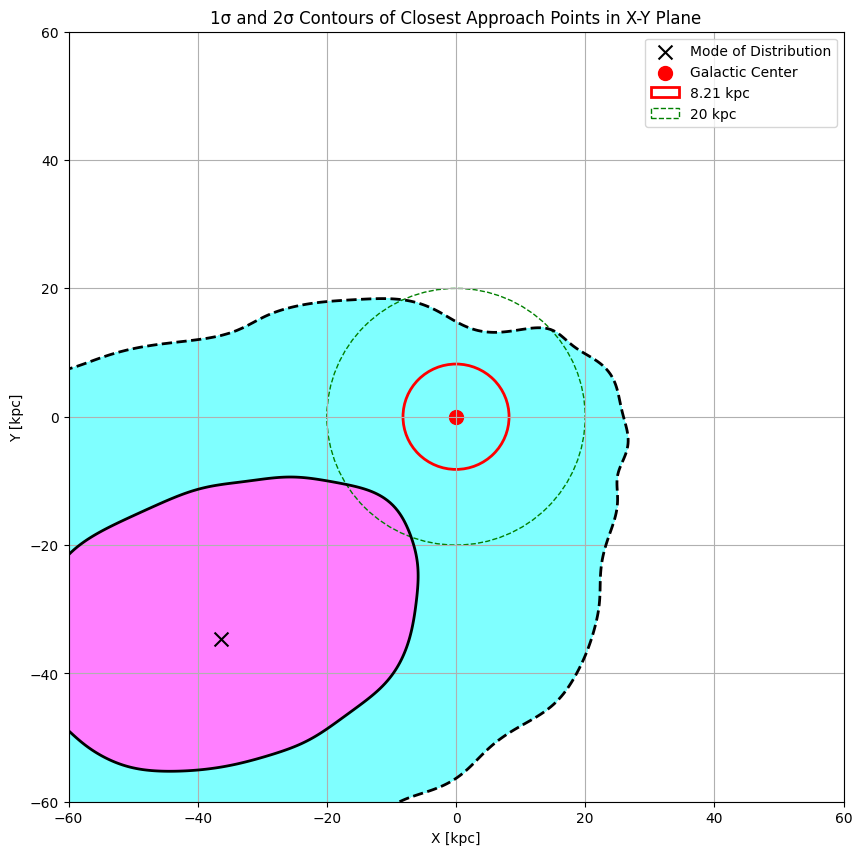

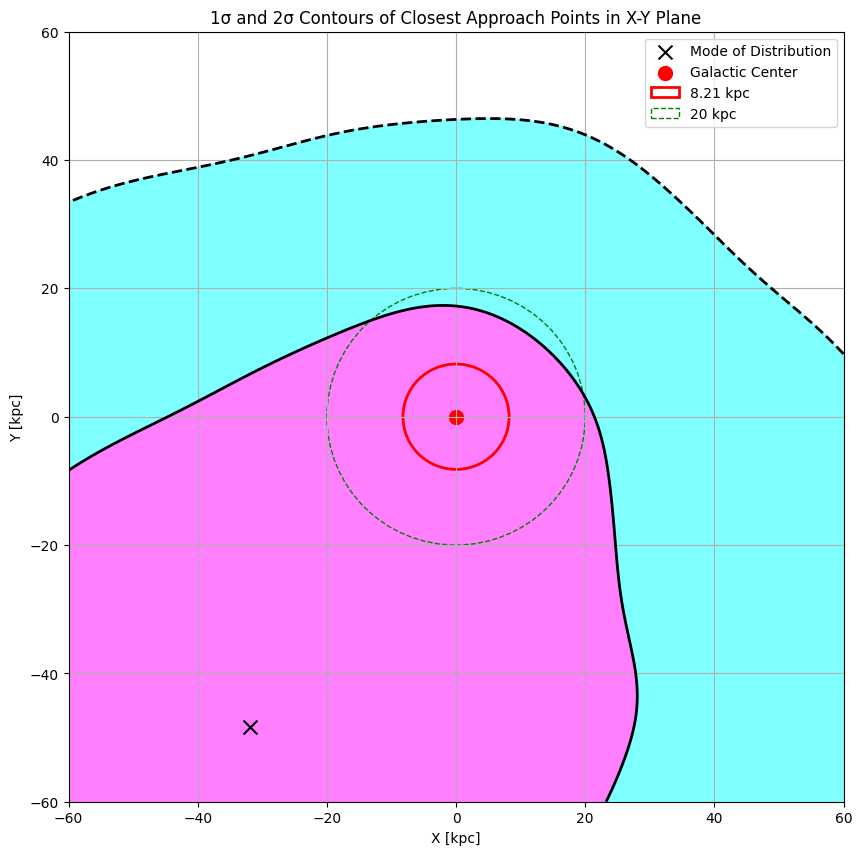

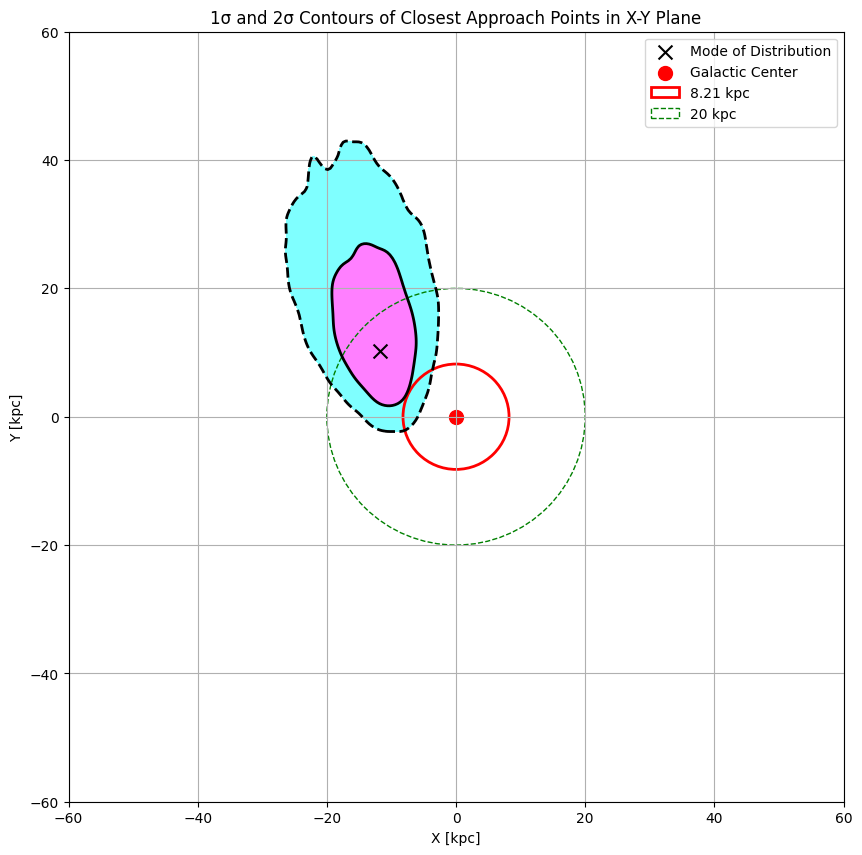

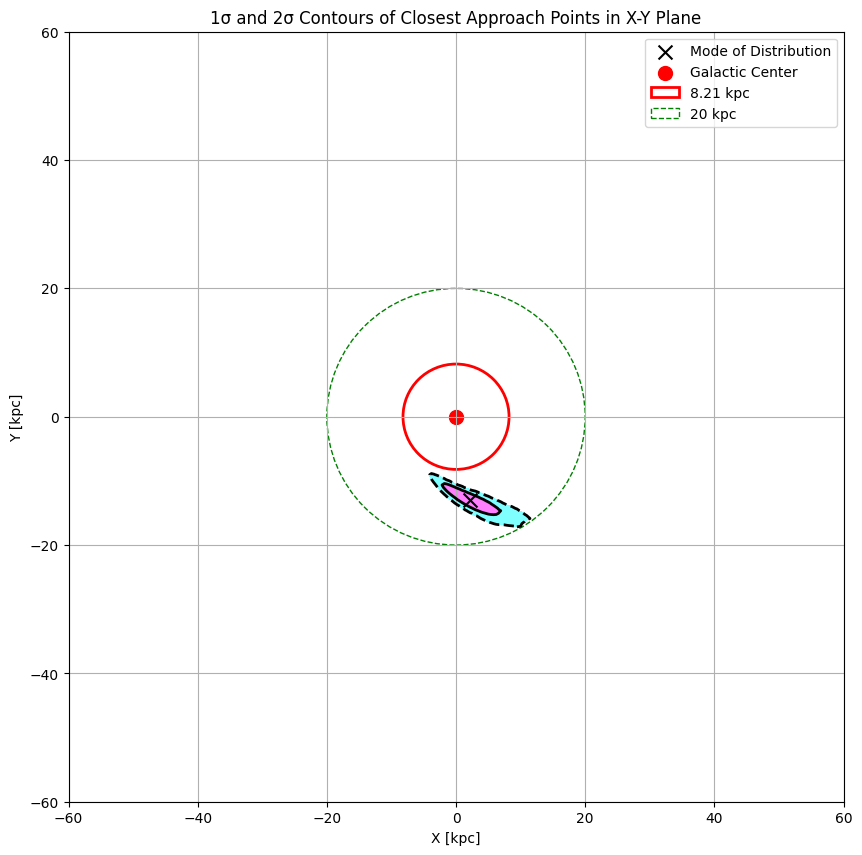

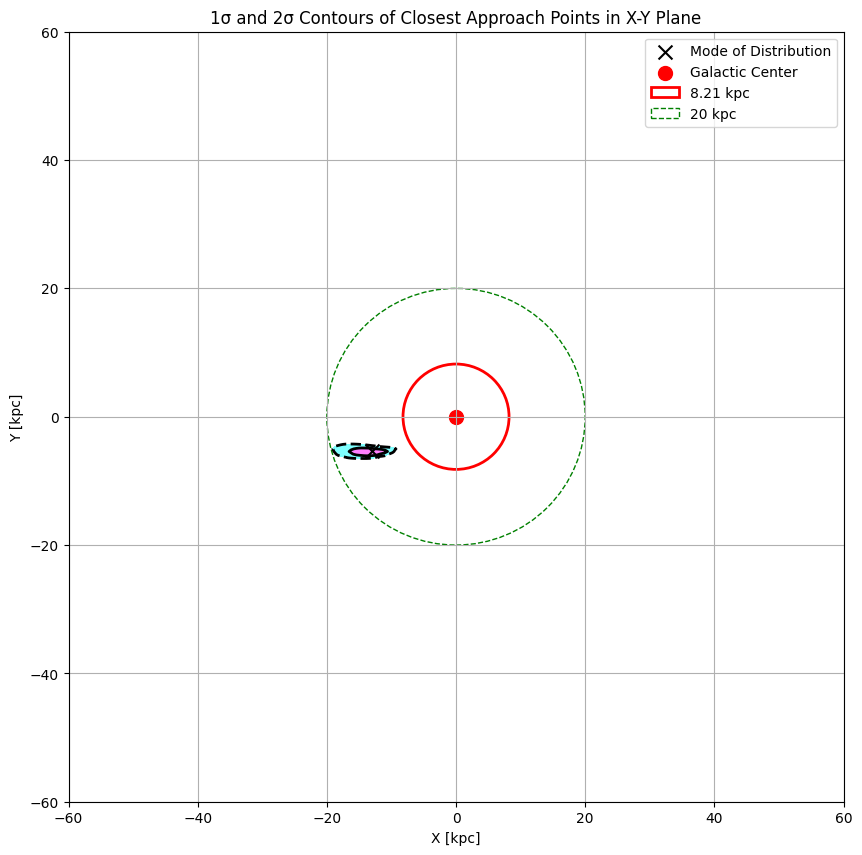

ValueError during contour plotting: Contour levels must be increasing


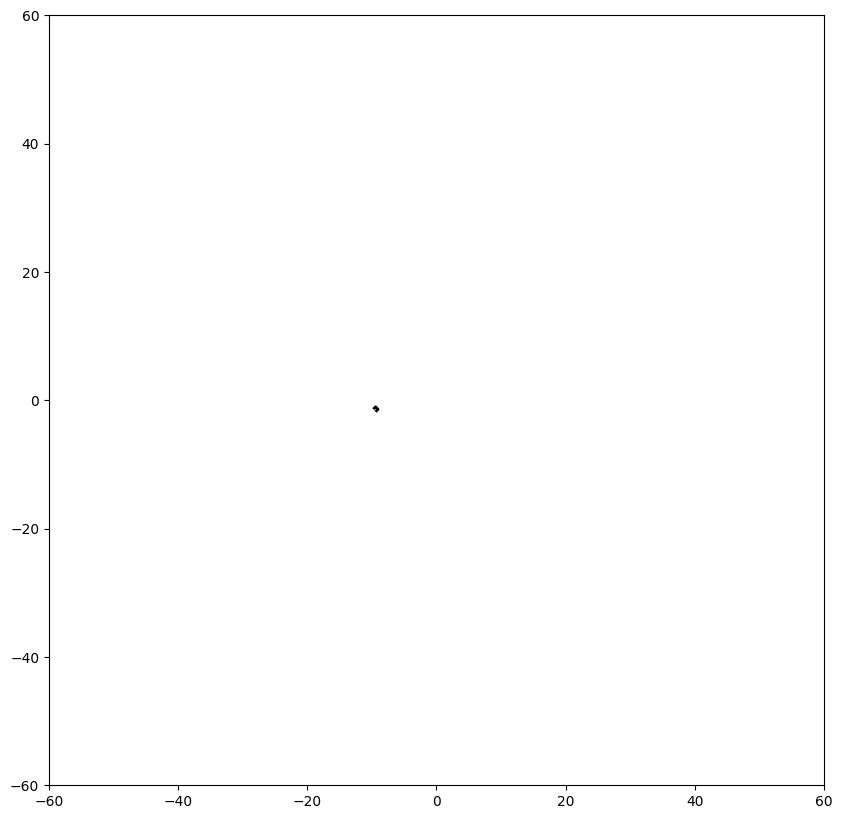

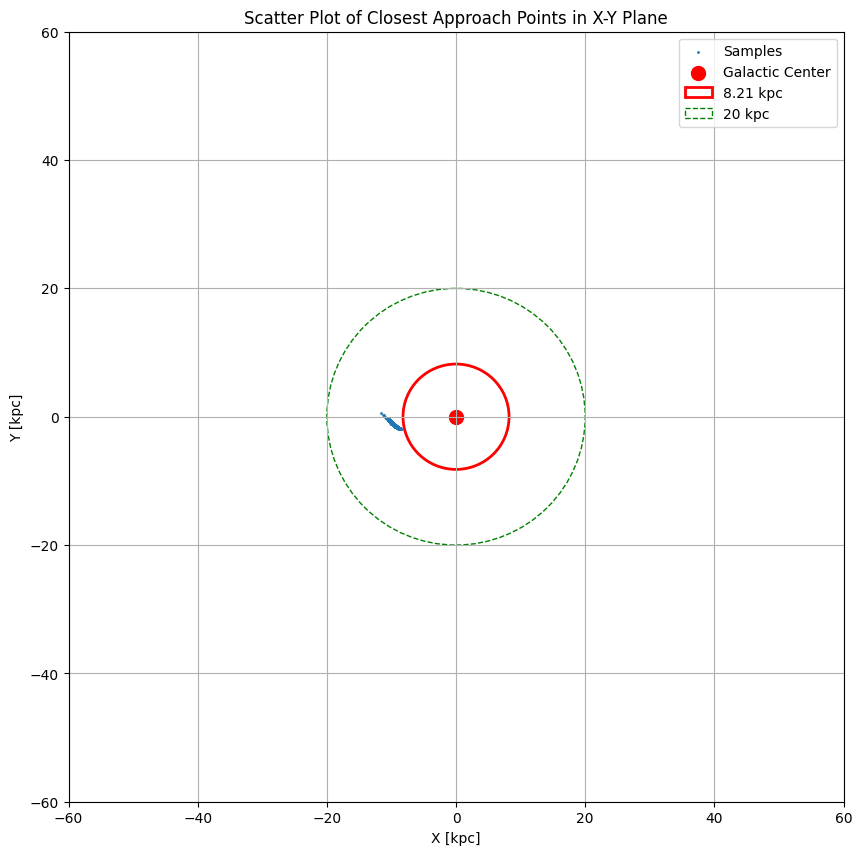

In [ ]:
save_path = 'Plots/brown_stars/brown_potential_gaia_dr3_pm'
for i in range(len(brown_data)):
    plot_sigma_contours(plane_crossings[i], star_name=brown_data.iloc[[i]].ID.values[0], save_path=save_path)

[7.25304443e-05]
[4.67897636e-71]
[9.90581788e-33]
[0.00153353]
[1.15307796e-09]
[3.30556828e-23]
[1.45643817e-07]
[9.70958956e-05]
[0.00196846]
[5.69316277e-05]
[3.74955691e-05]
[5.42320907e-08]
[0.]
[0.]
[0.]


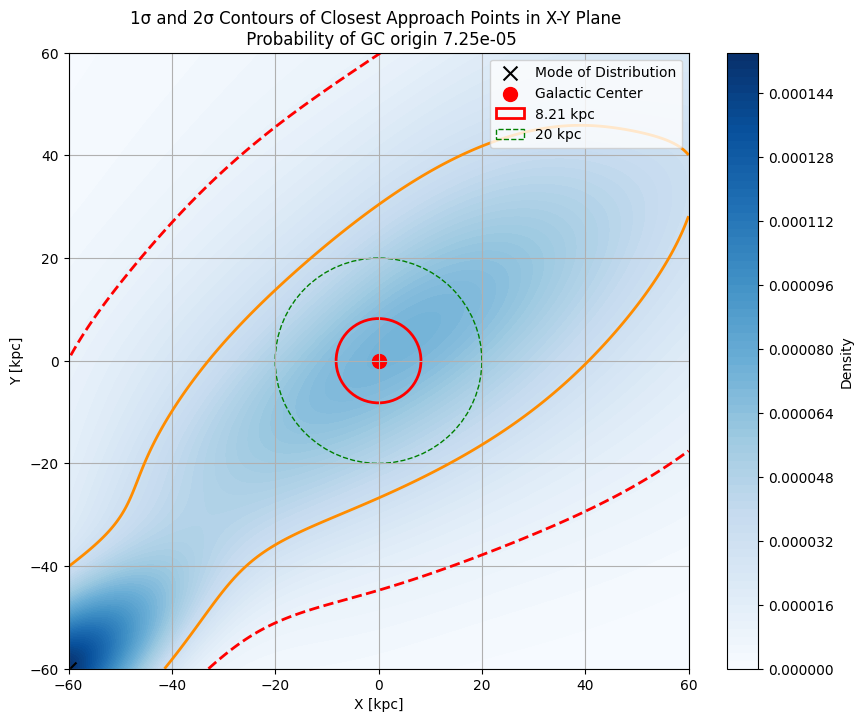

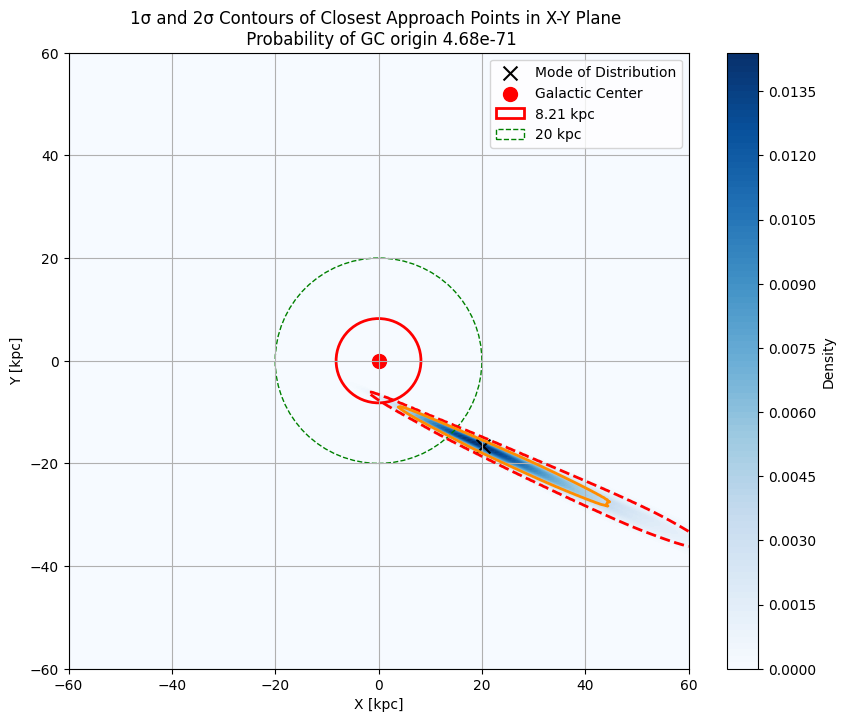

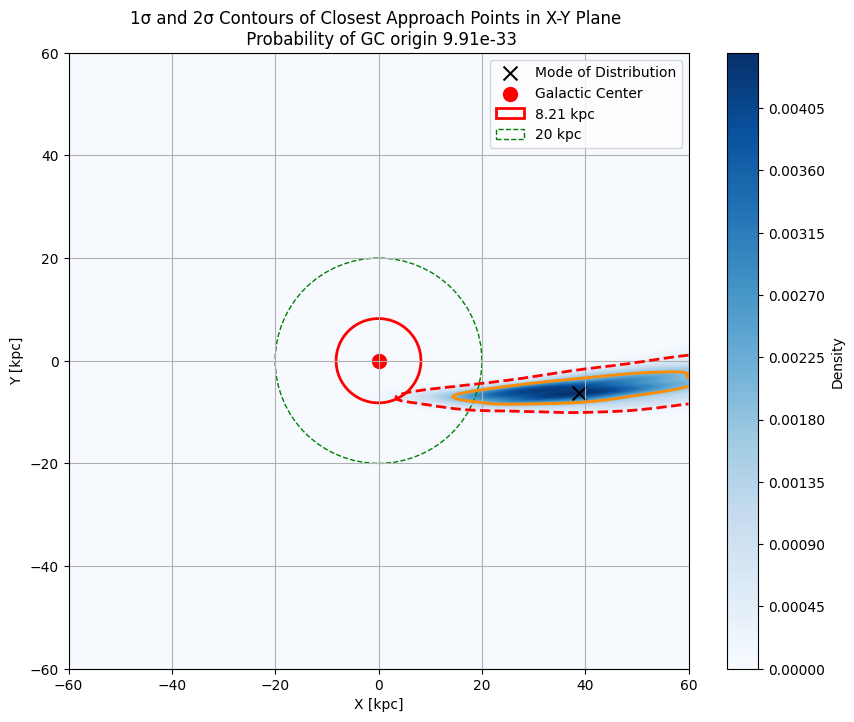

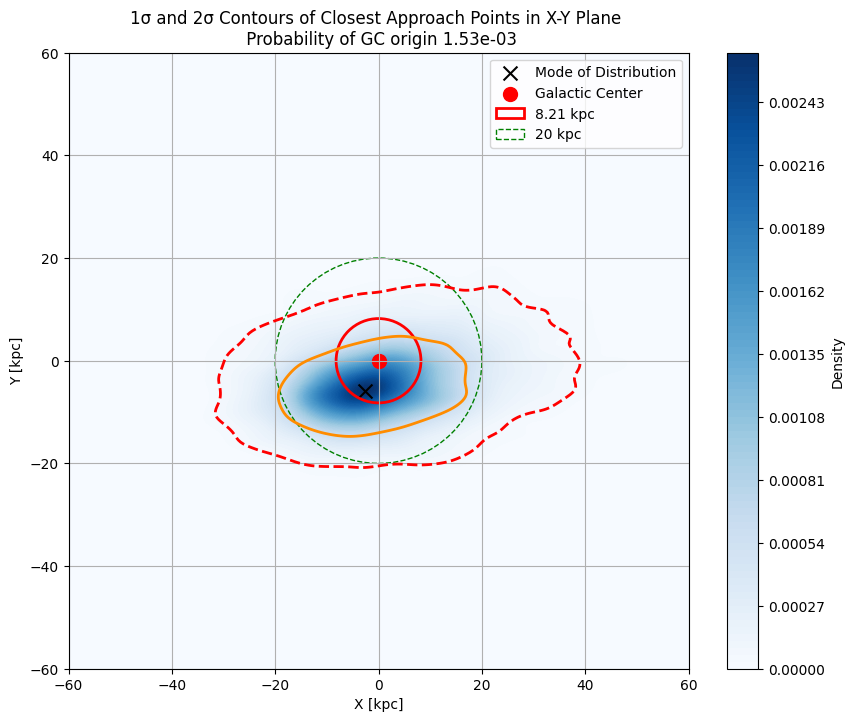

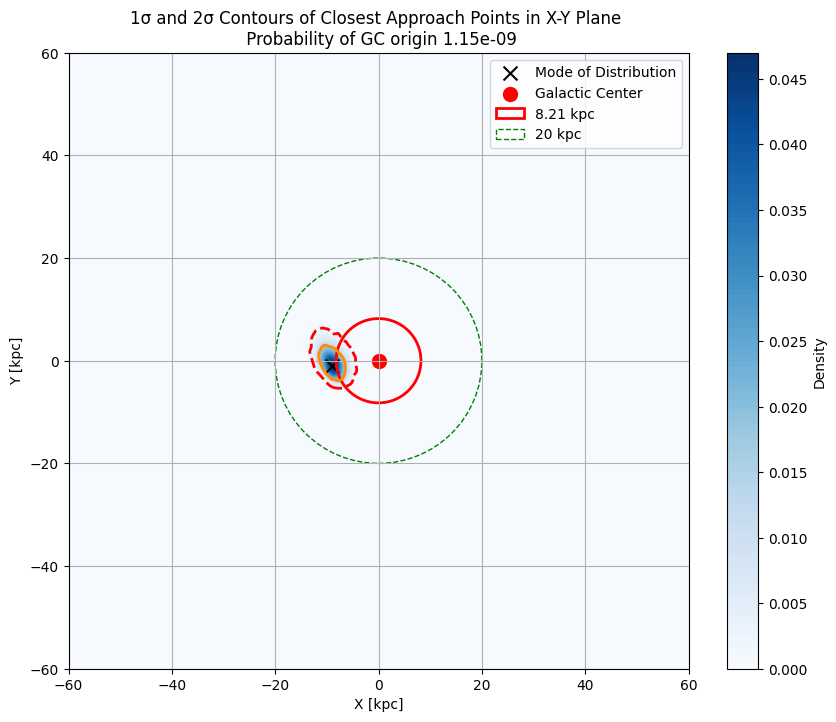

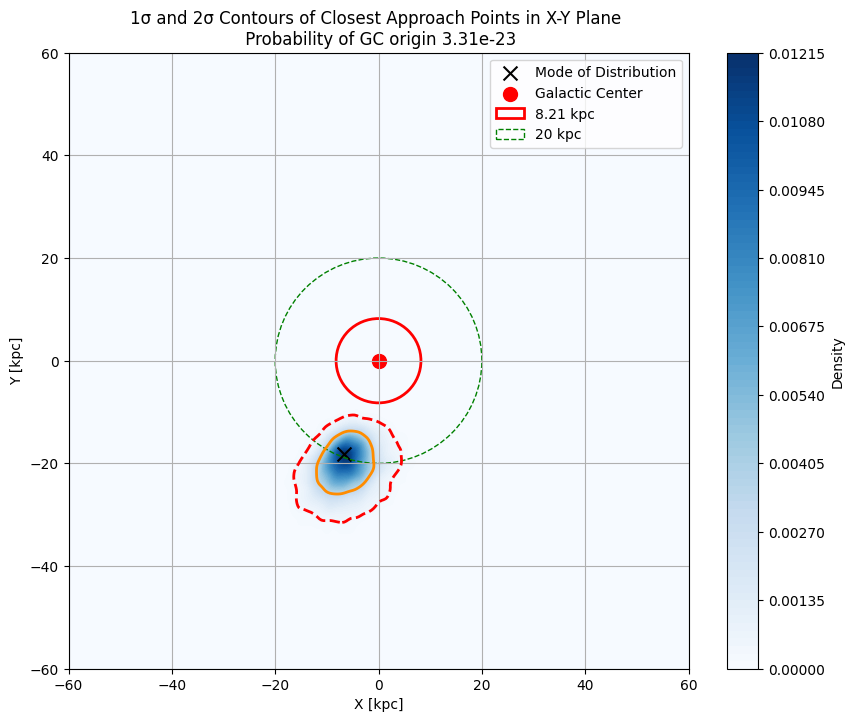

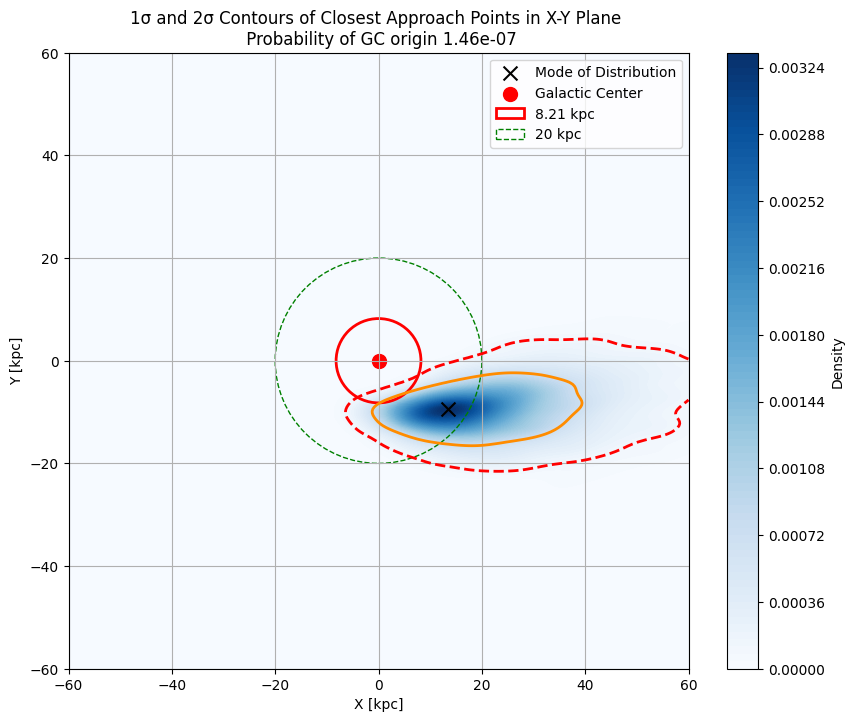

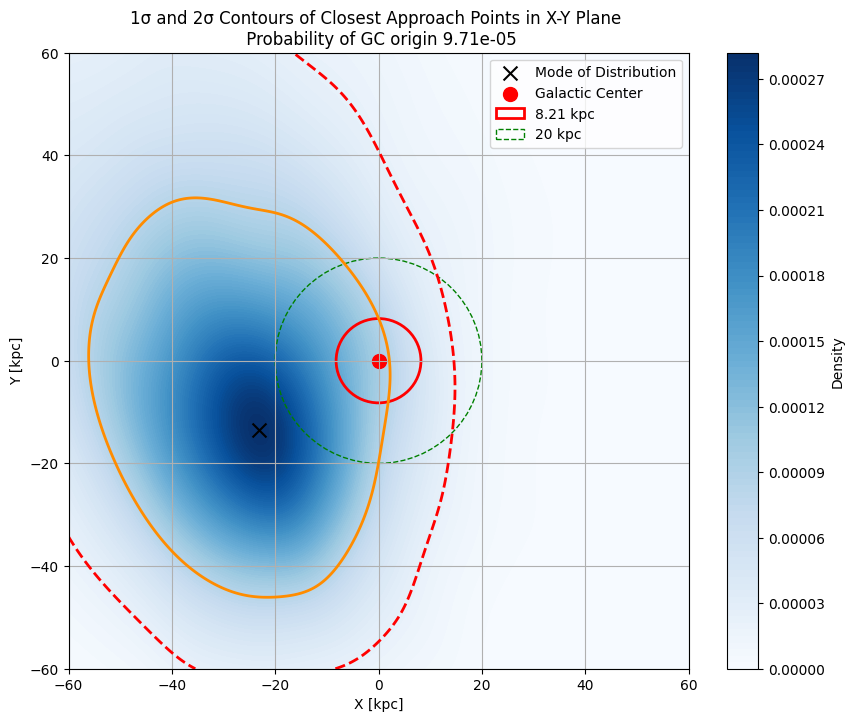

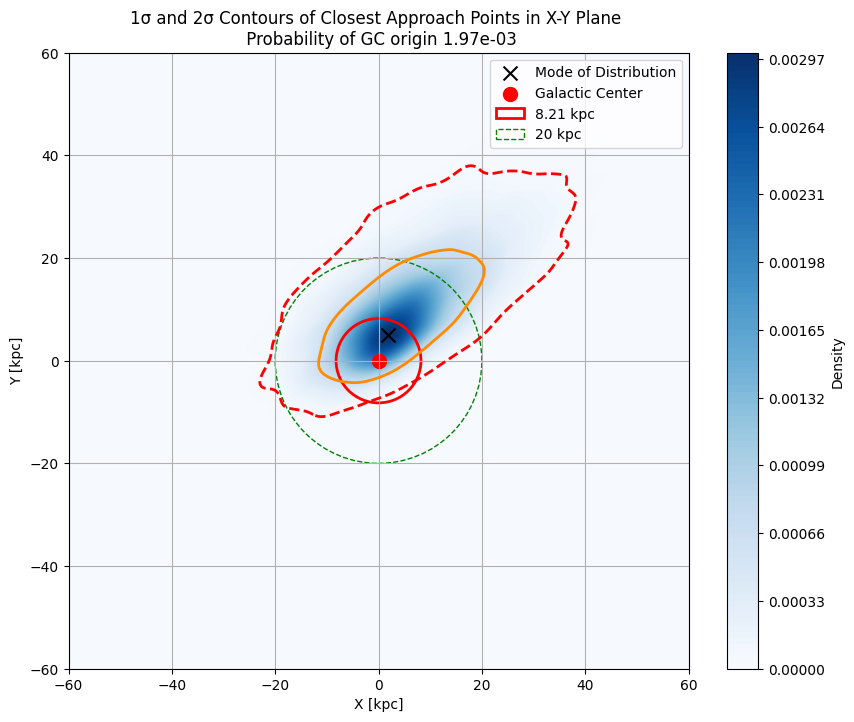

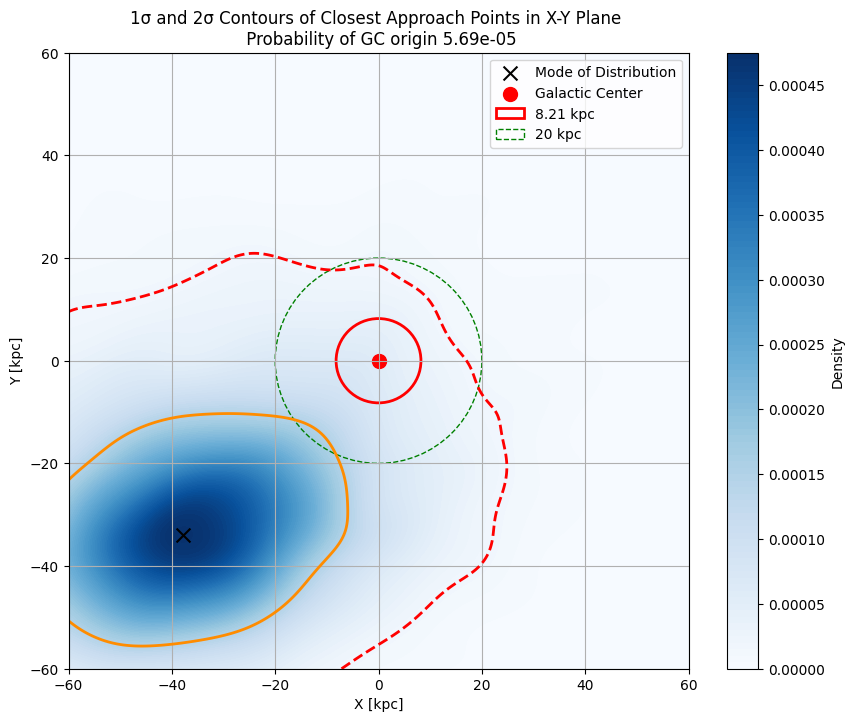

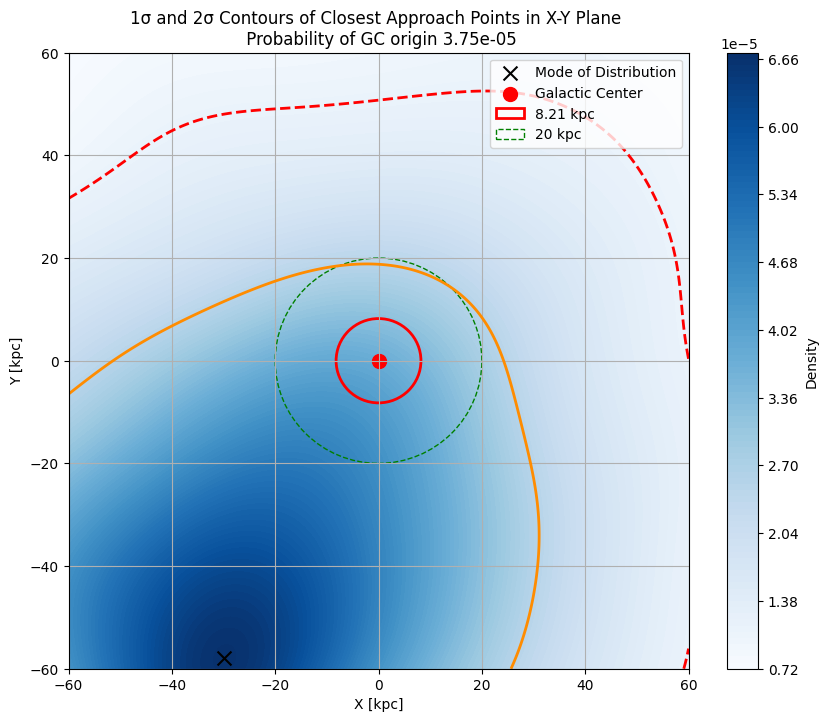

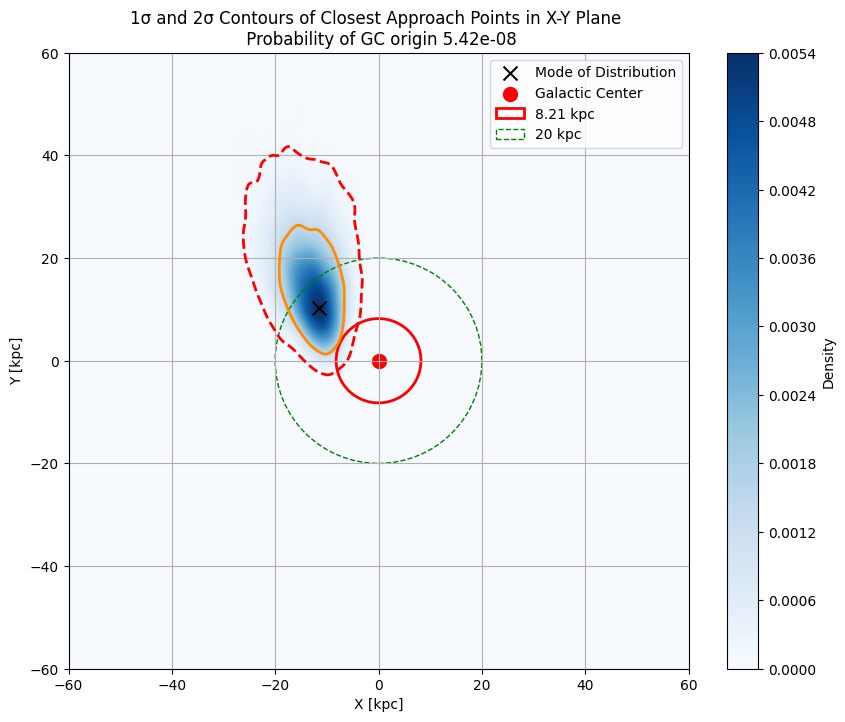

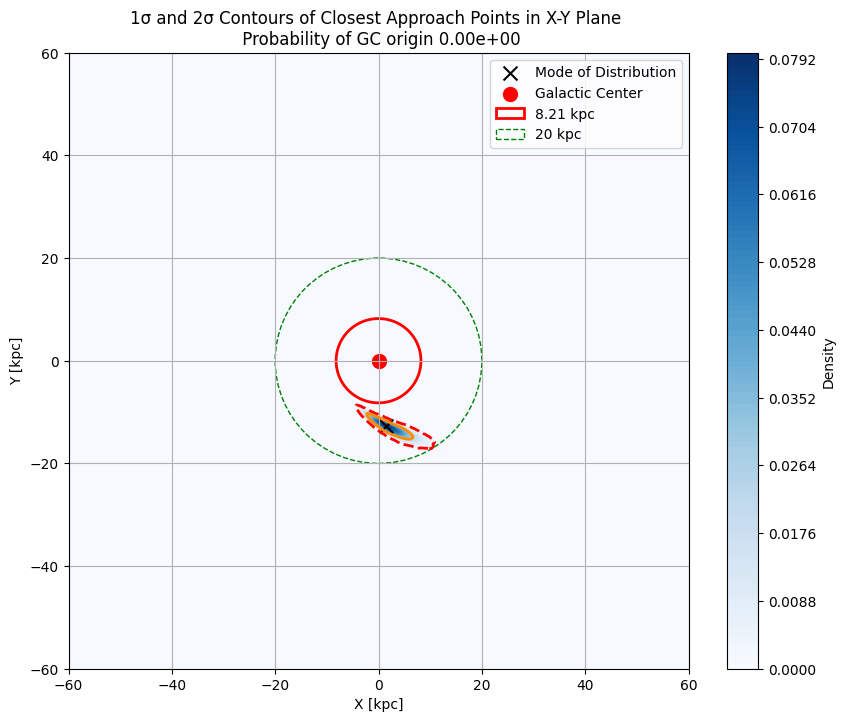

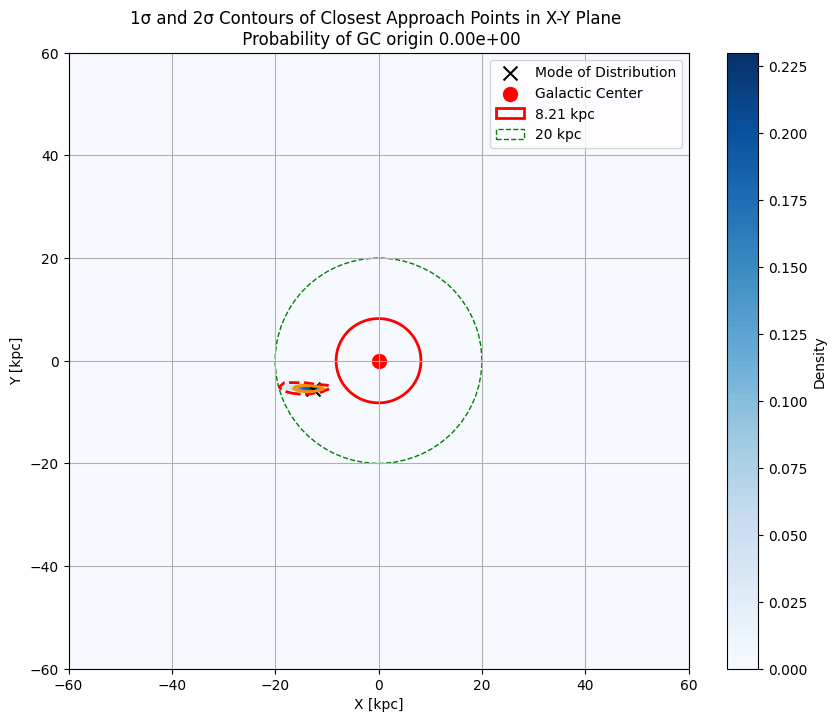

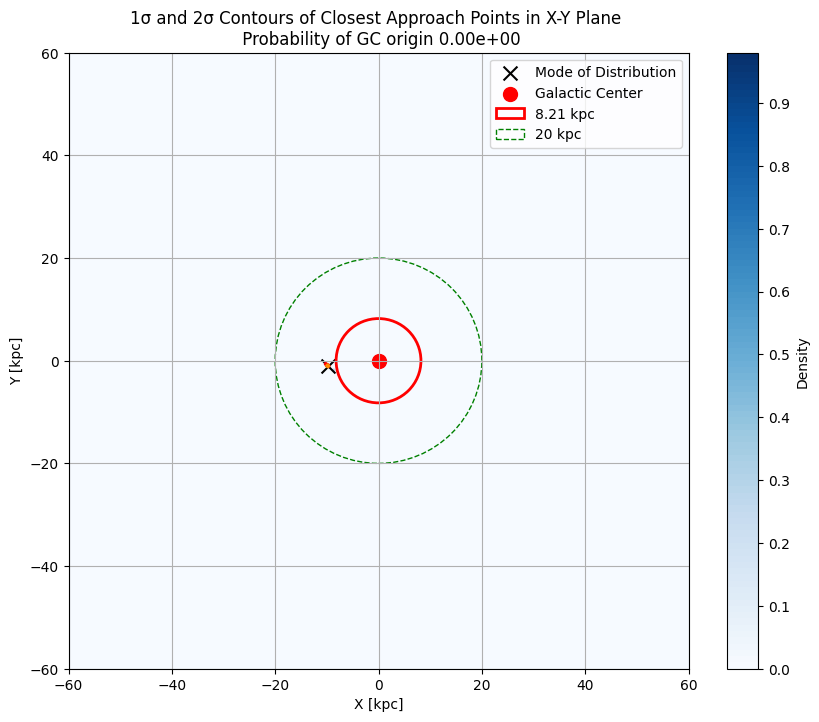

In [ ]:
# test new plotting function
save_path = 'Plots/brown_stars/brown_potential_gaia_dr3_pm_m'
for i in range(len(brown_data)):
    plot_sigma_contours_m(plane_crossings[i], star_name=brown_data.iloc[[i]].ID.values[0], save_path=save_path, save = True)

# Plane crossing using Gaia DR3 and McMillan17 potential

In [ ]:
# compute orbits for all brown stars using HST proper motions, this should give the exact same contours as Figure 4 in the paper
plane_crossings = []
for i in range(len(brown_data)):
    star = brown_data.iloc[[i]]
    plane_crossings.append(oia.integrate_orbits_to_plane_crossing_agama_parallel(star, n_samples=10000,
                                                        integration_time=-0.3,  
                                                        pmra_col='pmra',
                                                        pmdec_col='pmdec',
                                                        pmra_error_col='pmra_error',
                                                        pmdec_error_col='pmdec_error', 
                                                        potential_file='Agama/McMillan2011.pot'))

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1362.95it/s]


  0%|                                                                                                              | 0/15 [00:00<?, ?it/s]/tmp/ipykernel_22892/3213116668.py:53: UserWarning: The following kwargs were not used by contour: 'labels'
  plt.contour(xi, yi, zi, levels=[level_2sigma, level_1sigma, zi.max()], colors=['k', 'k', 'k'],
 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎      | 14/15 [01:30<00:06,  6.43s/it]


ValueError: Contour levels must be increasing

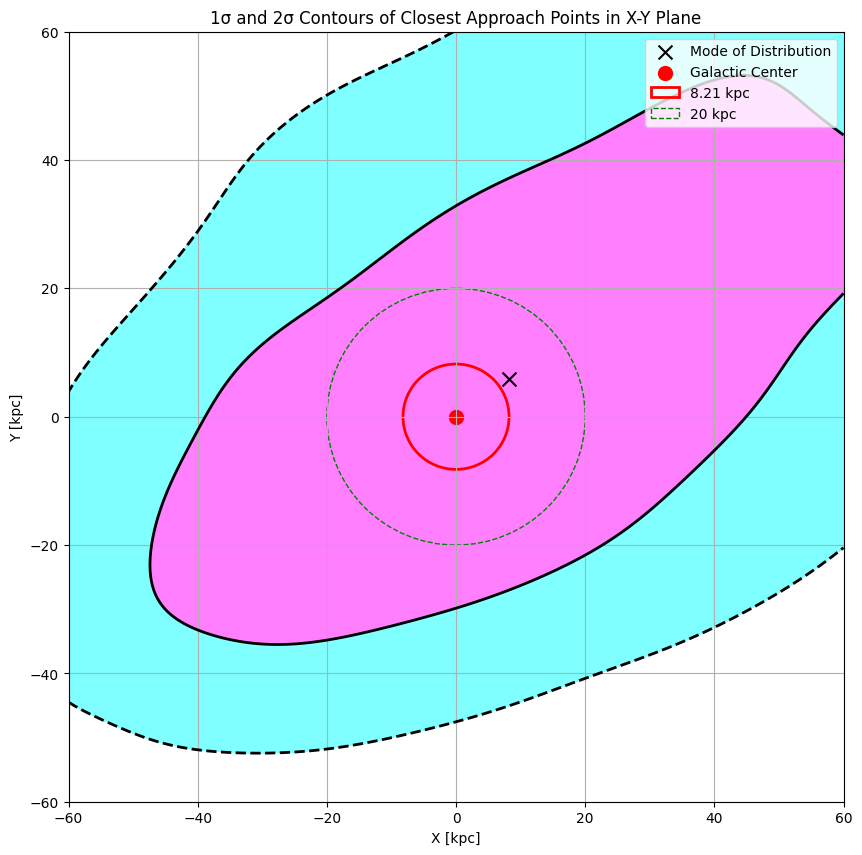

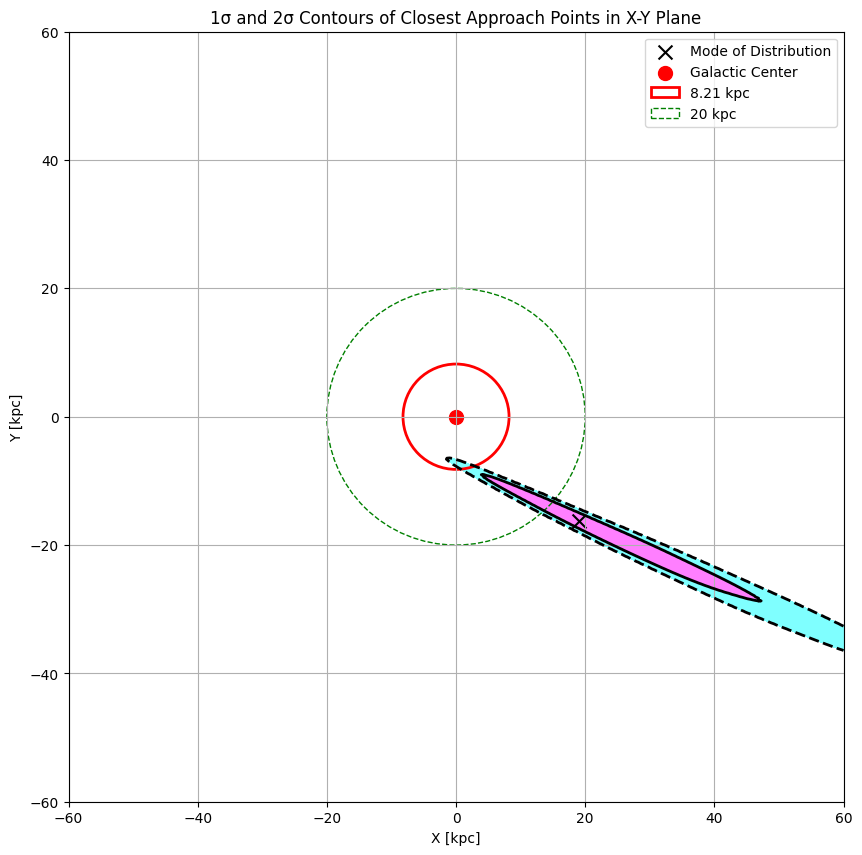

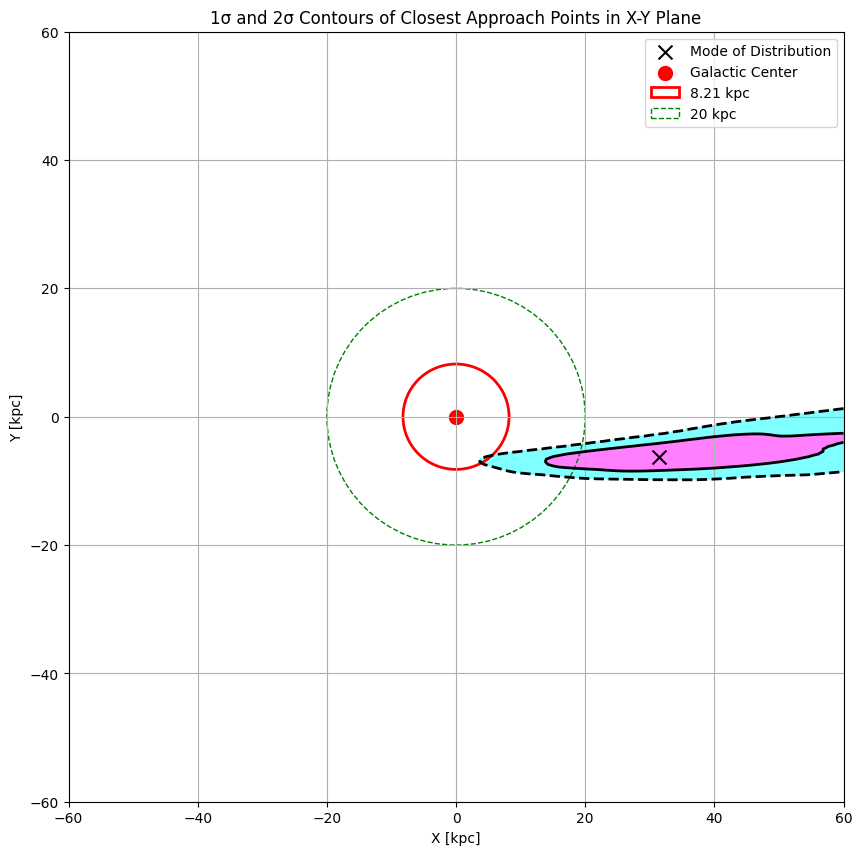

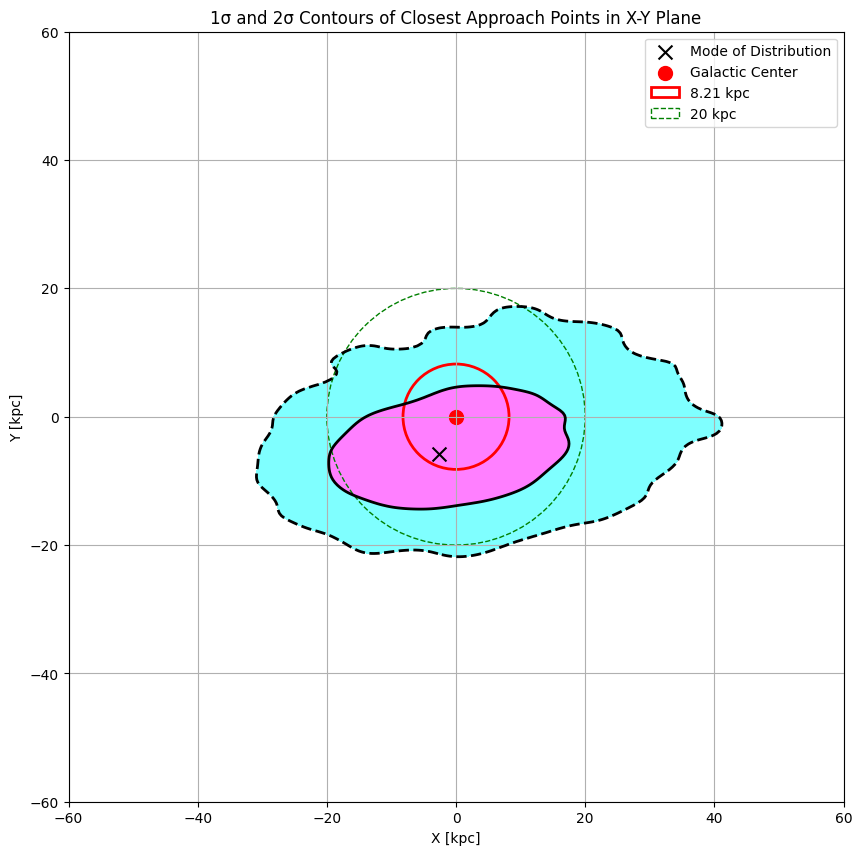

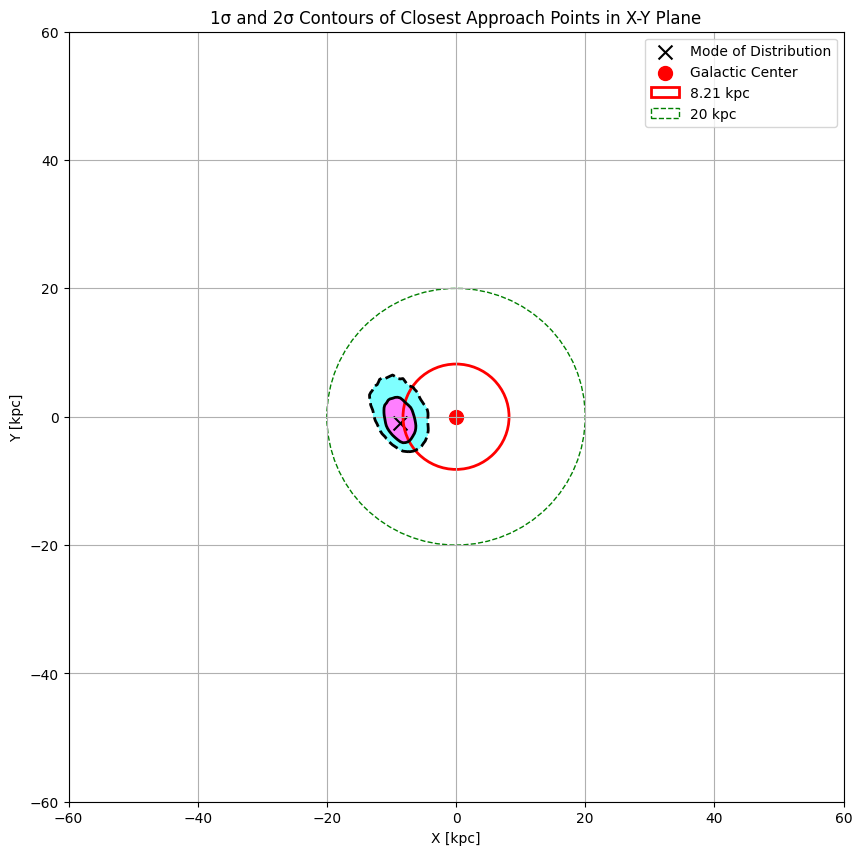

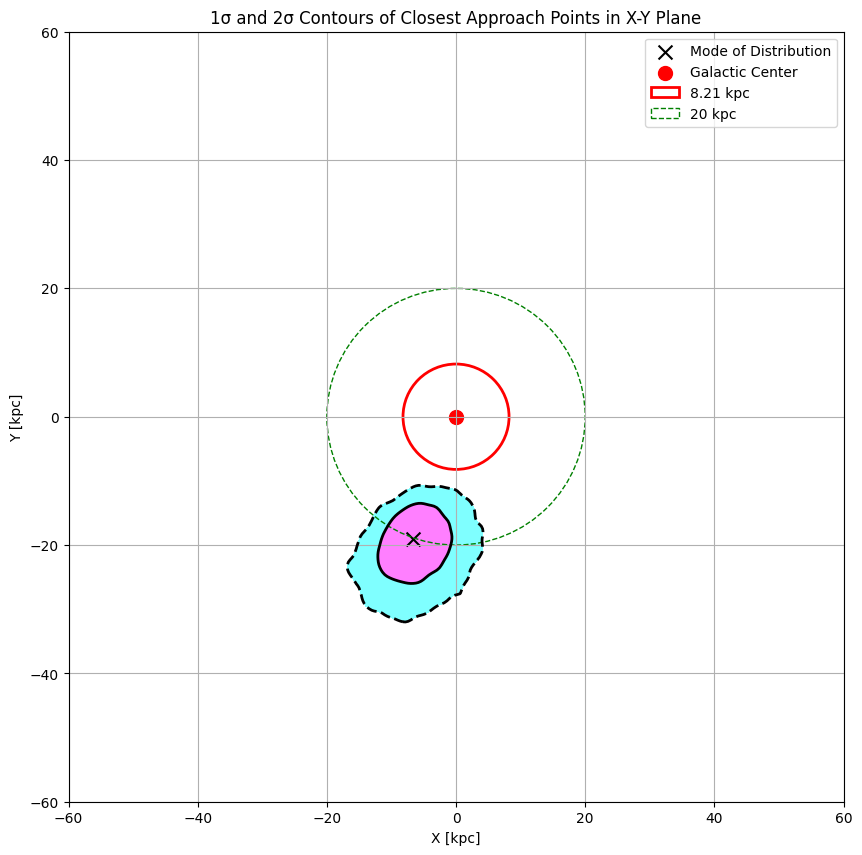

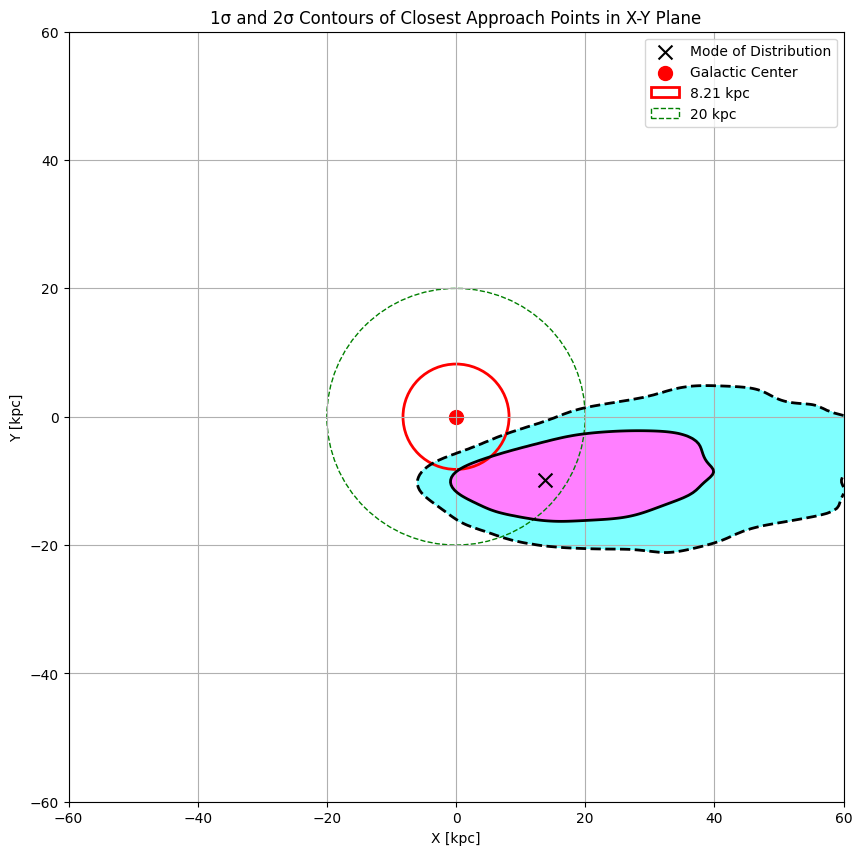

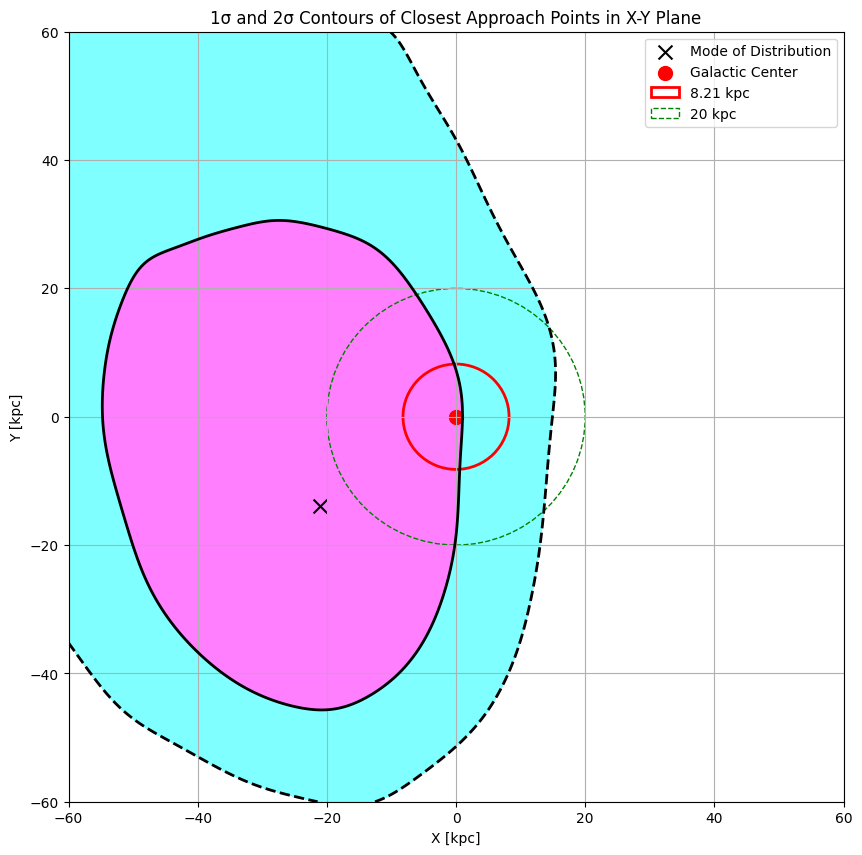

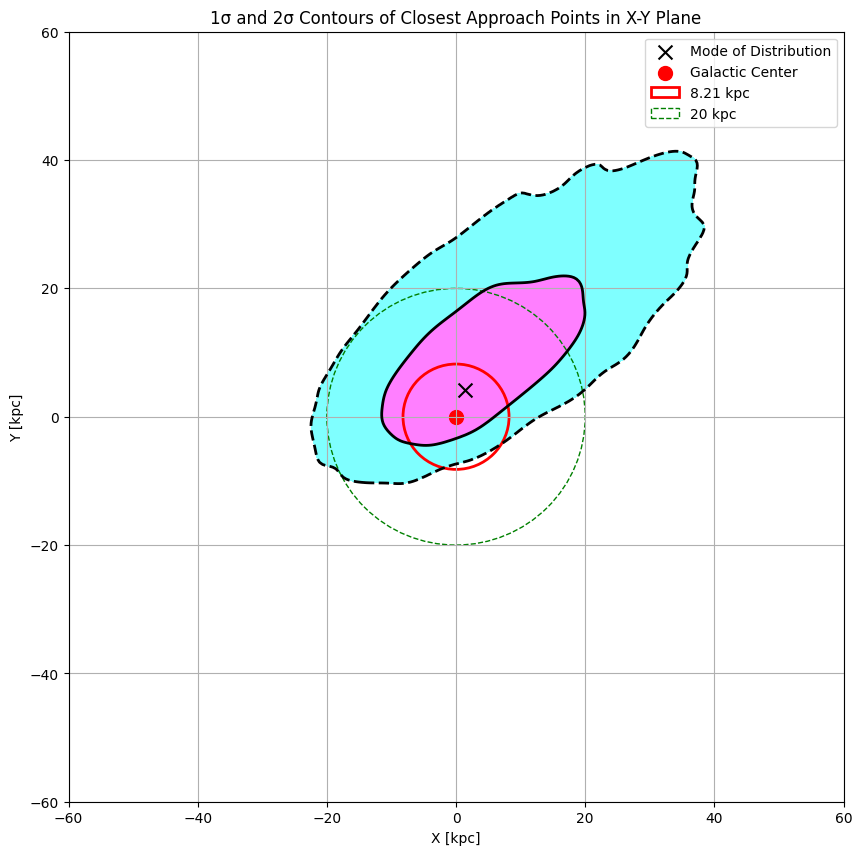

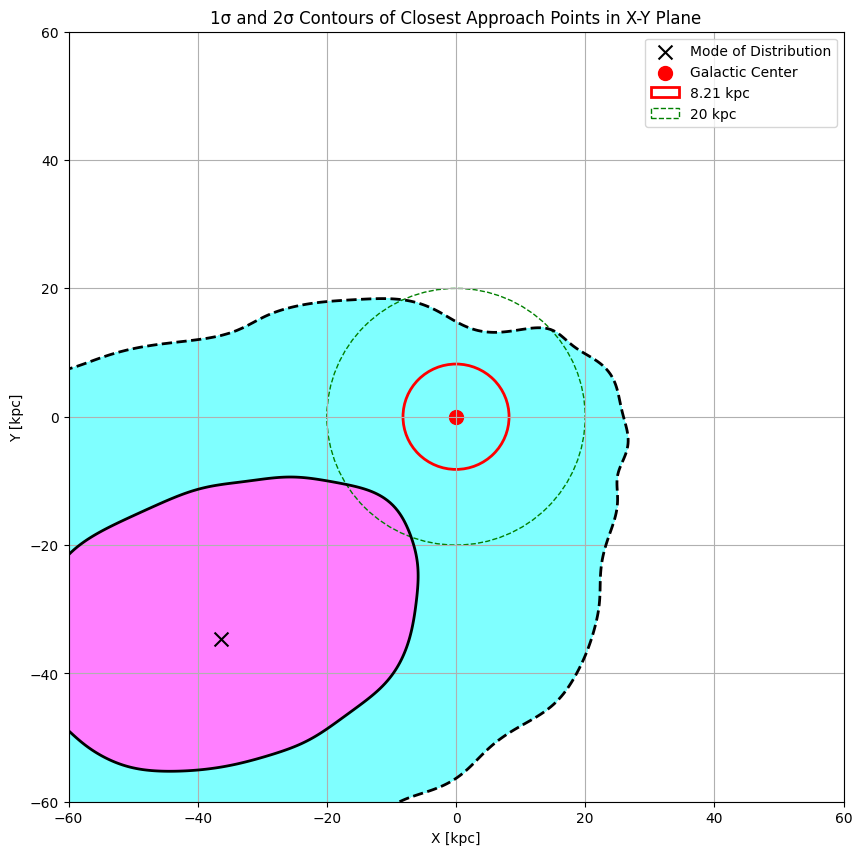

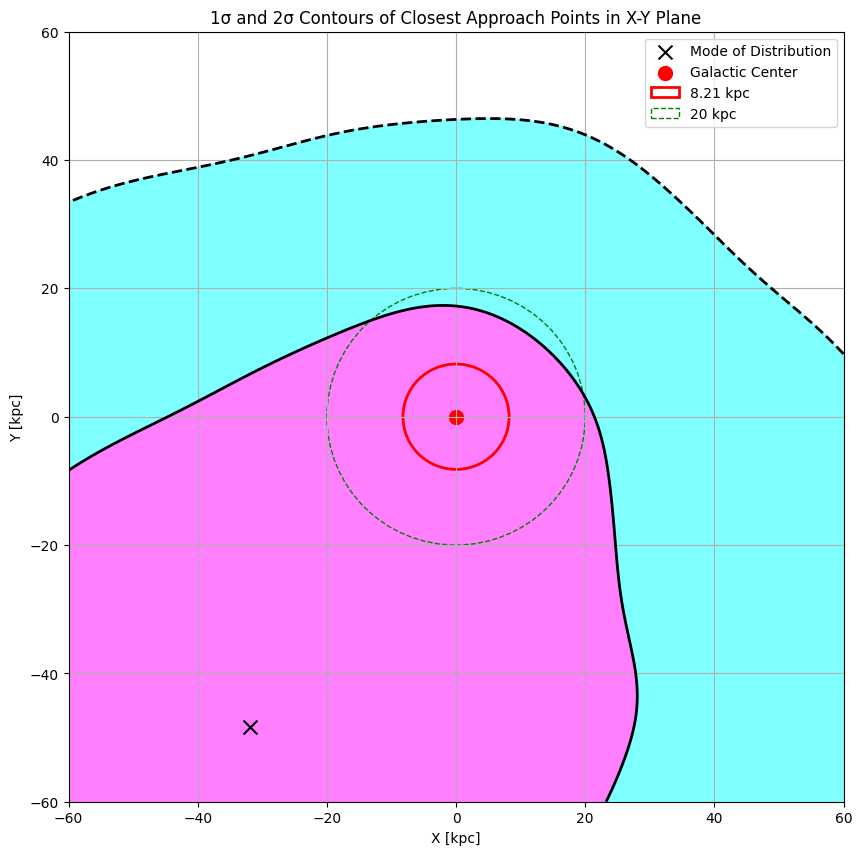

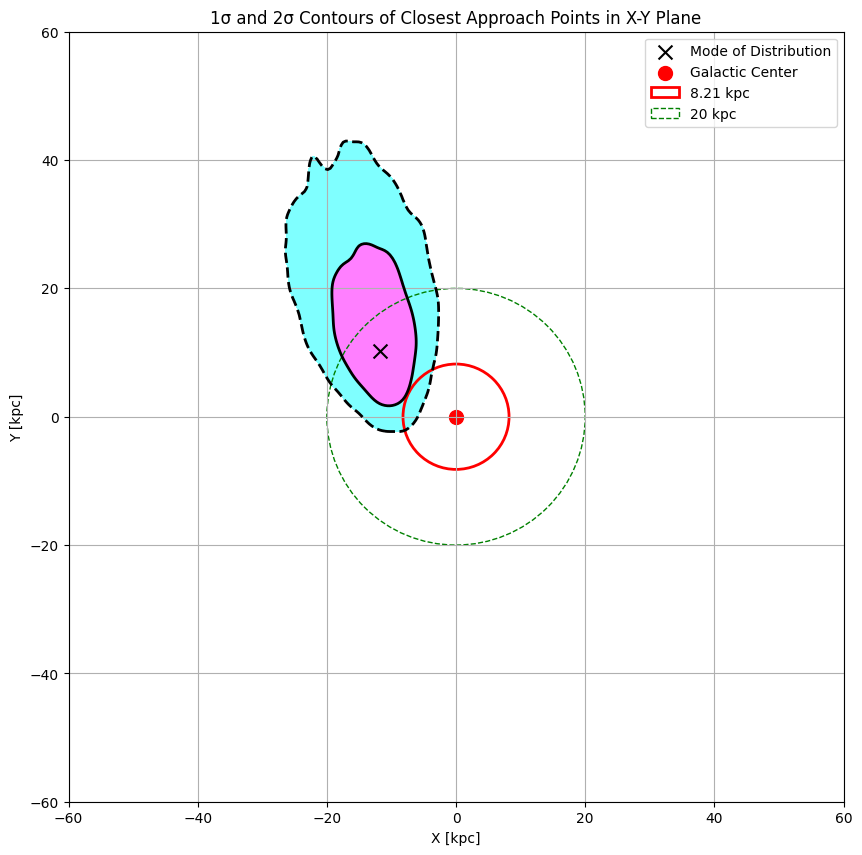

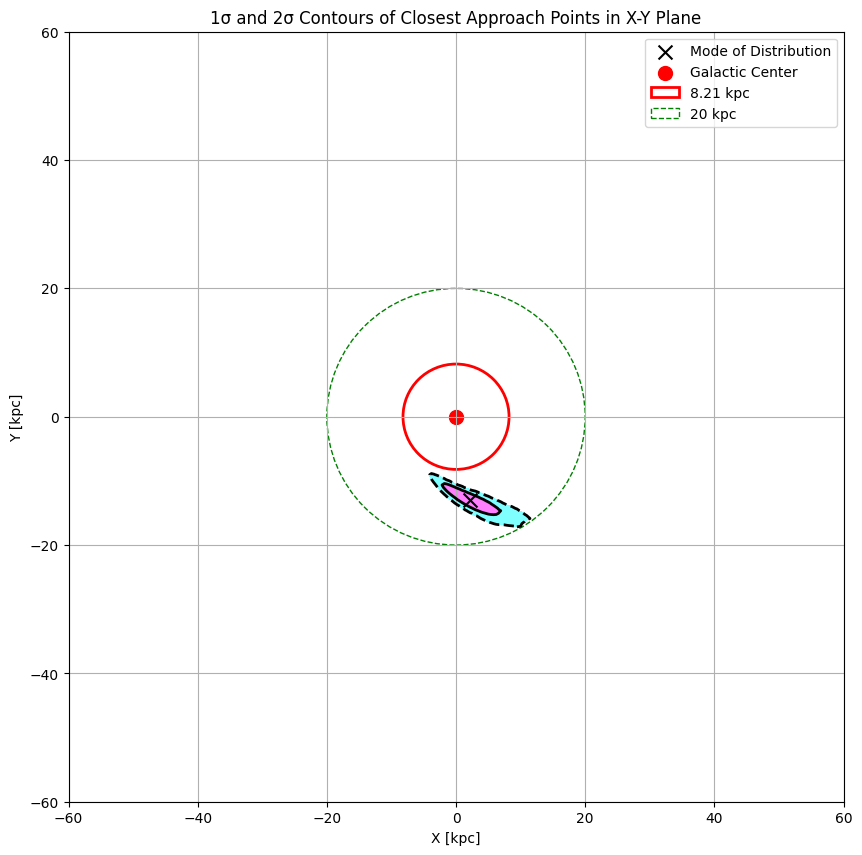

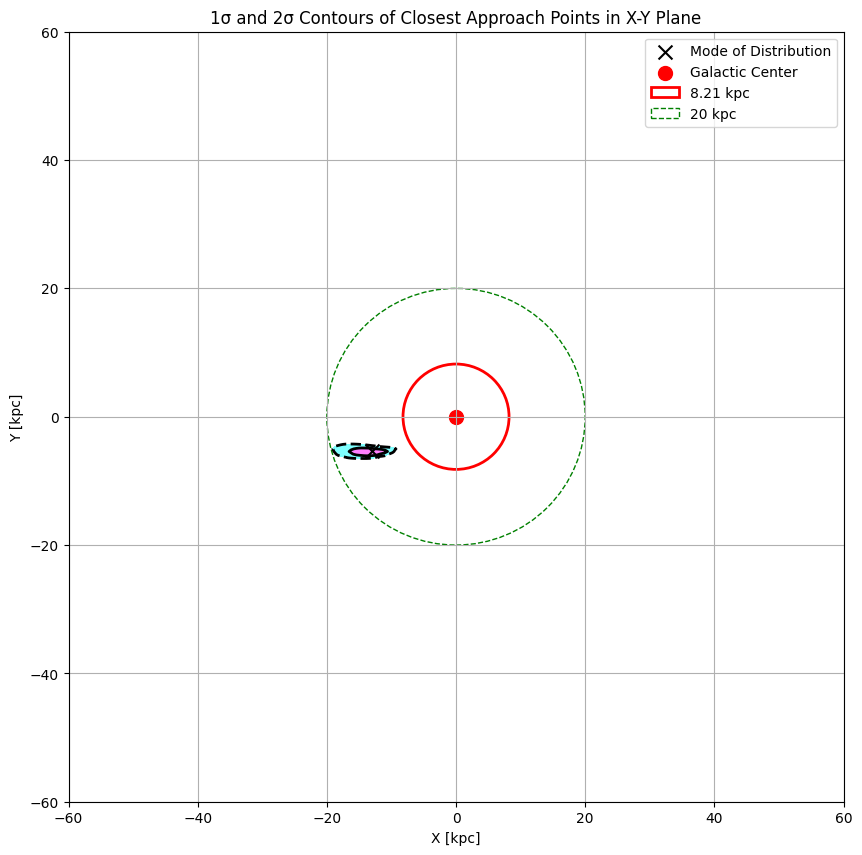

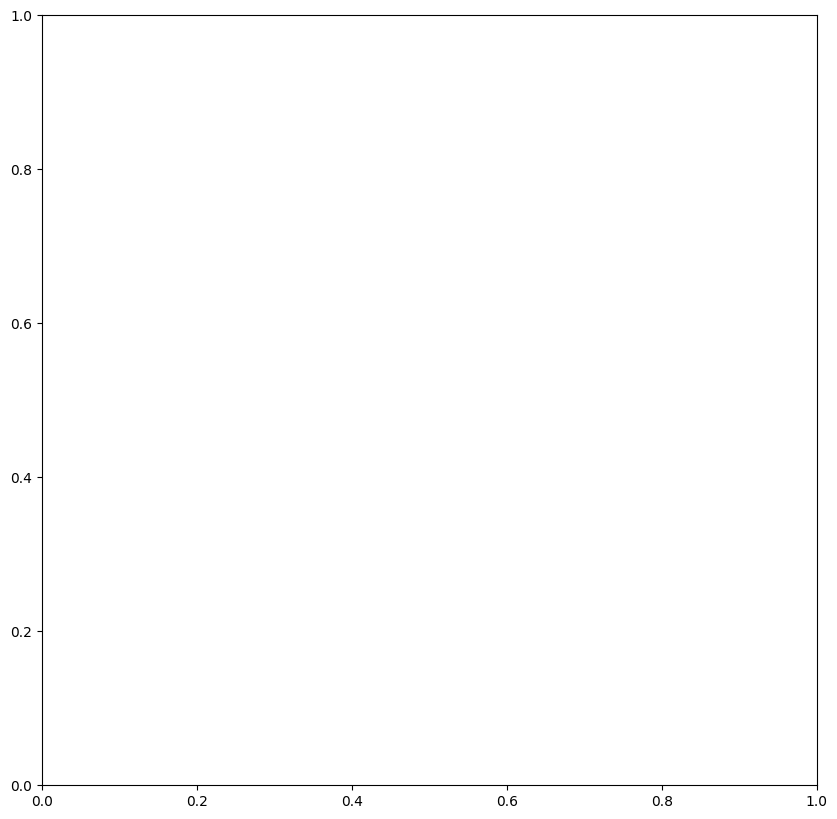

In [ ]:
save_path = 'Plots/brown_stars/mcmillan2017_potential_gaia_dr3_pm'
for i in tqdm(range(len(brown_data))):
    plot_sigma_contours(plane_crossings[i], star_name=brown_data.iloc[[i]].ID.values[0], save_path=save_path, save=True)

# Compute plane crossing positions with HST + Gaia proper motions

## HVS1

In [ ]:
# load hvs1 data, this one does not applied a rewind
hvs1 = Table.read('Data/Brown_targets/hvs1_hubblexgaia.fits')
hvs1 = hvs1.to_pandas()
hvs1.rename(columns={'ra_1': 'ra', 'dec_1': 'dec'}, inplace=True)

plane_crossings_hvs1 = oia.integrate_orbits_to_plane_crossing_agama_parallel(hvs1, n_samples=10000,
                                                        integration_time=-0.05,  
                                                        pmra_col='hst_gaia_pmra_wmean',
                                                        pmdec_col='hst_gaia_pmdec_wmean',
                                                        pmra_error_col='hst_gaia_pmra_median_error',
                                                        pmdec_error_col='hst_gaia_pmdec_median_error', 
                                                        potential_file='Agama/brown2015.pot')
                                                        

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1433.56it/s]


/tmp/ipykernel_10430/1267025119.py:45: UserWarning: The following kwargs were not used by contour: 'labels'
  plt.contour(xi, yi, zi, levels=[level_2sigma, level_1sigma, zi.max()], colors=['k', 'k', 'k'],


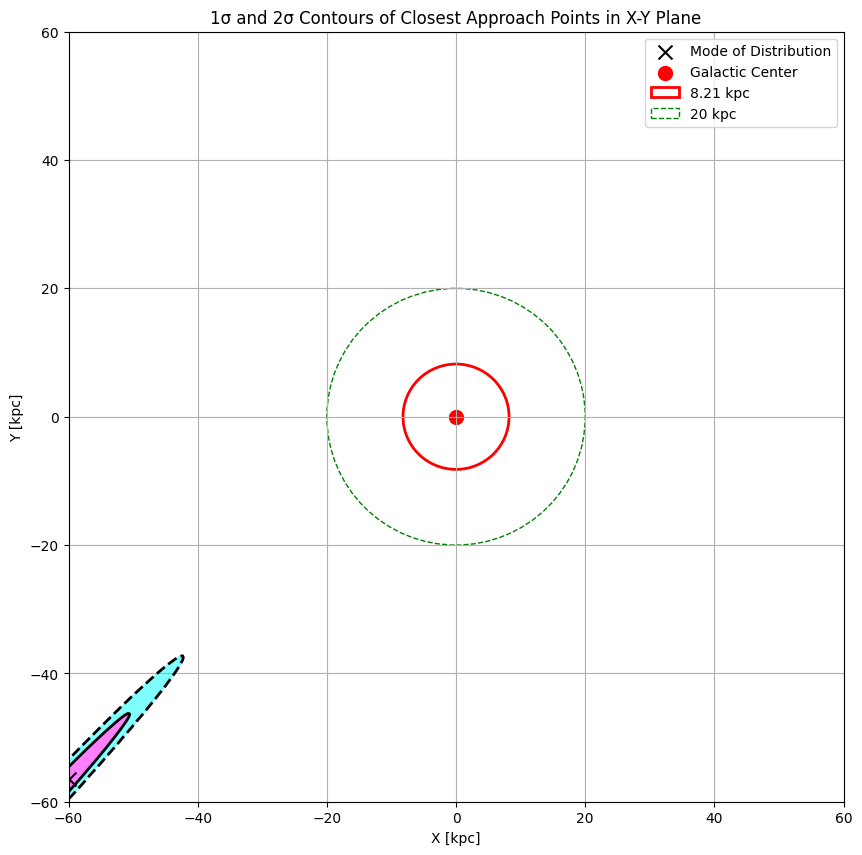

In [ ]:
plot_sigma_contours(plane_crossings_hvs1)

## HVS1 with McMillan

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1368.34it/s]
/tmp/ipykernel_10430/1267025119.py:45: UserWarning: The following kwargs were not used by contour: 'labels'
  plt.contour(xi, yi, zi, levels=[level_2sigma, level_1sigma, zi.max()], colors=['k', 'k', 'k'],


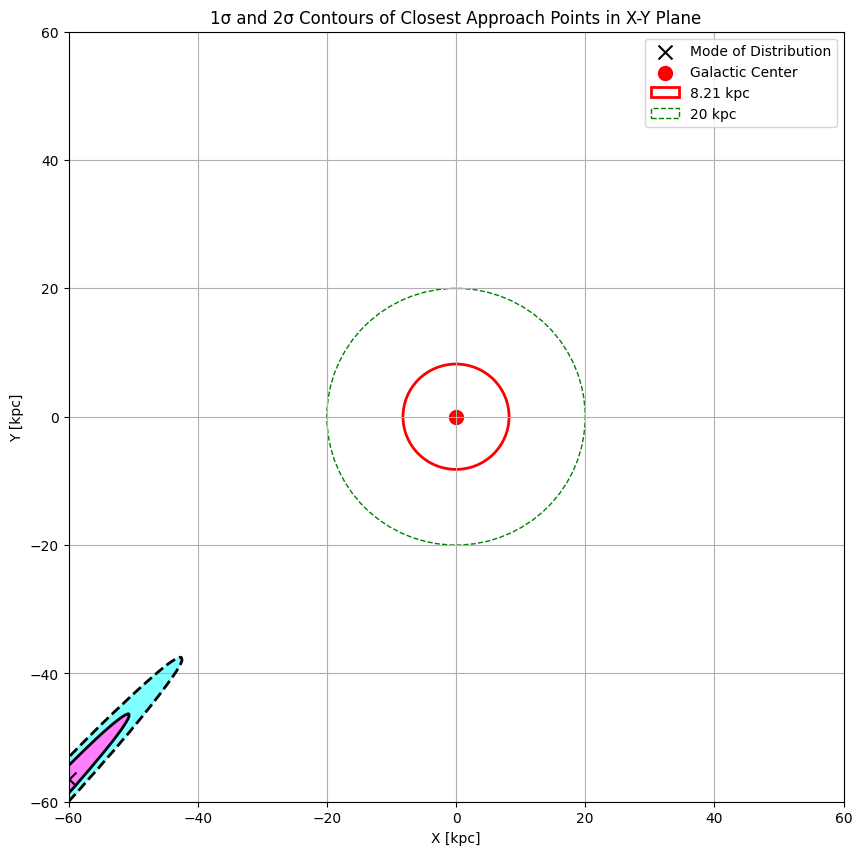

In [ ]:
# load hvs1 data, this one does not applied a rewind
hvs1 = Table.read('Data/Brown_targets/hvs1_hubblexgaia.fits')
hvs1 = hvs1.to_pandas()
hvs1.rename(columns={'ra_1': 'ra', 'dec_1': 'dec'}, inplace=True)

plane_crossings_hvs1 = oia.integrate_orbits_to_plane_crossing_agama_parallel(hvs1, n_samples=10000,
                                                        integration_time=-0.05,  
                                                        pmra_col='hst_gaia_pmra_wmean',
                                                        pmdec_col='hst_gaia_pmdec_wmean',
                                                        pmra_error_col='hst_gaia_pmra_median_error',
                                                        pmdec_error_col='hst_gaia_pmdec_median_error', 
                                                        potential_file='Agama/McMillan2011.pot')
plot_sigma_contours(plane_crossings_hvs1)
                                                        

## HVS4

In [ ]:
# load data for HVS 4
# load data 
hvs4 = Table.read('Data/Brown_targets/hvs4_hubblexgaia_rewind.fits')
hvs4 = hvs4.to_pandas()
hvs4.rename(columns={'ra_1': 'ra', 'dec_1': 'dec'}, inplace=True)

In [ ]:
plane_crossings_hvs4 = oia.integrate_orbits_to_plane_crossing_agama_parallel(hvs4, n_samples=10000,
                                                        integration_time=-0.3,  
                                                        pmra_col='hst_gaia_pmra_wmean',
                                                        pmdec_col='hst_gaia_pmdec_wmean',
                                                        pmra_error_col='hst_gaia_pmra_wmean_error',
                                                        pmdec_error_col='hst_gaia_pmdec_wmean_error', 
                                                        potential_file='Agama/brown2015.pot')
                                                        

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1256.30it/s]


/tmp/ipykernel_10430/1267025119.py:45: UserWarning: The following kwargs were not used by contour: 'labels'
  plt.contour(xi, yi, zi, levels=[level_2sigma, level_1sigma, zi.max()], colors=['k', 'k', 'k'],


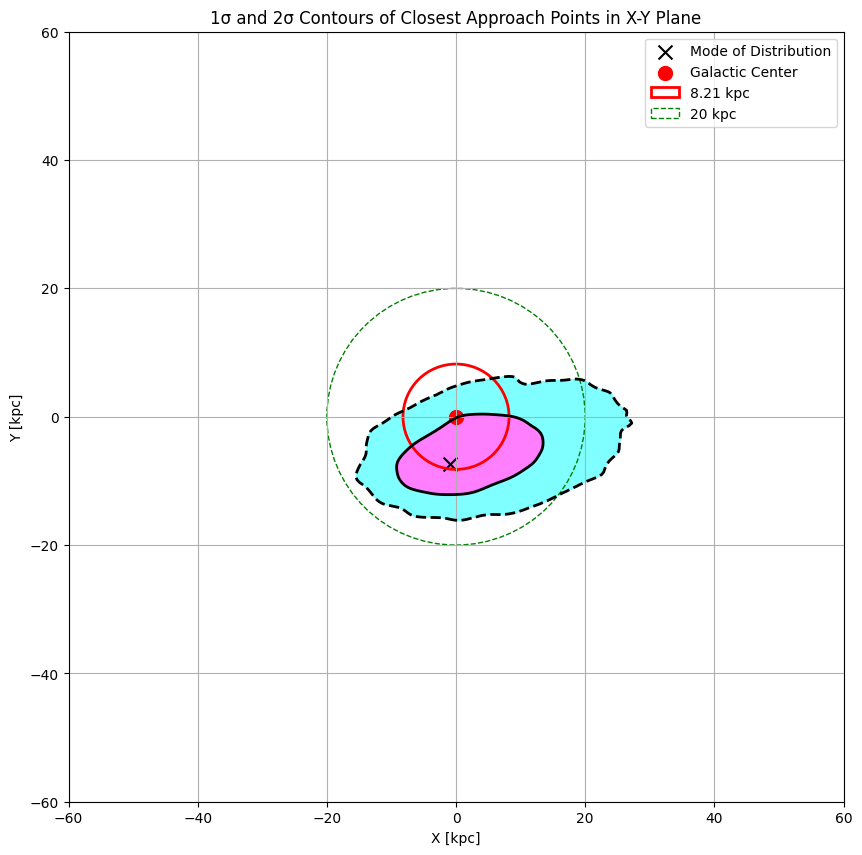

In [ ]:
plot_sigma_contours(plane_crossings_hvs4)

## HVS4 with McMillan

In [ ]:
plane_crossings_hvs4 = oia.integrate_orbits_to_plane_crossing_agama_parallel(hvs4, n_samples=10000,
                                                        integration_time=-0.3,  
                                                        pmra_col='hst_gaia_pmra_wmean',
                                                        pmdec_col='hst_gaia_pmdec_wmean',
                                                        pmra_error_col='hst_gaia_pmra_wmean_error',
                                                        pmdec_error_col='hst_gaia_pmdec_wmean_error', 
                                                        potential_file='Agama/McMillan2011.pot')
                                                        

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1237.37it/s]


/tmp/ipykernel_10430/1267025119.py:45: UserWarning: The following kwargs were not used by contour: 'labels'
  plt.contour(xi, yi, zi, levels=[level_2sigma, level_1sigma, zi.max()], colors=['k', 'k', 'k'],


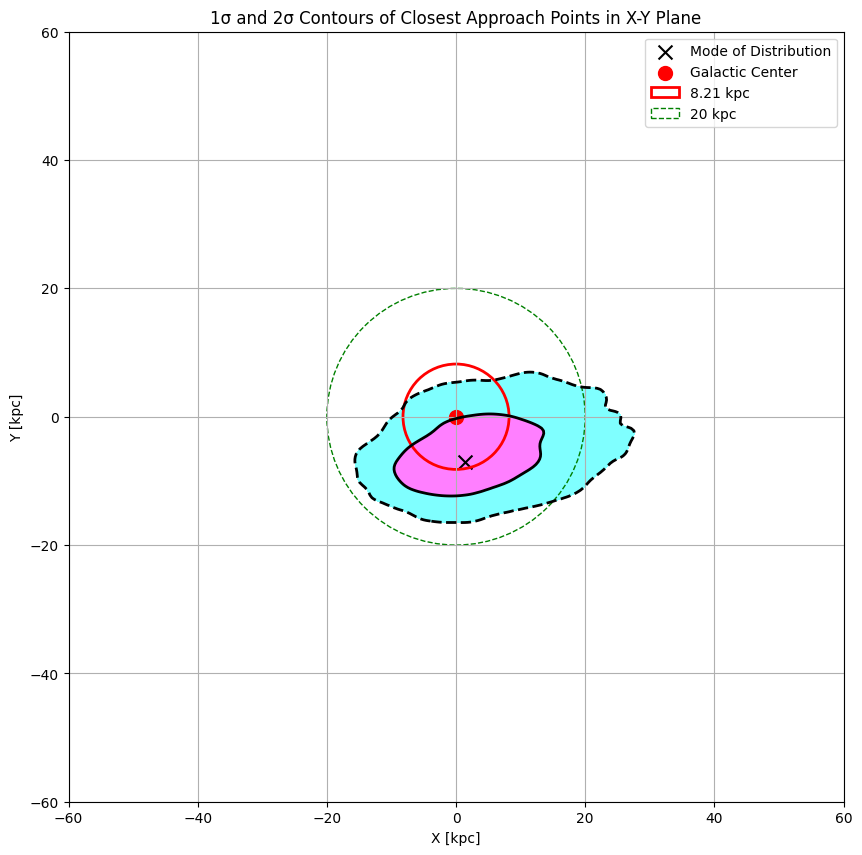

In [ ]:
plot_sigma_contours(plane_crossings_hvs4)

## HVS2

In [ ]:

# load data for HVS 4
# load data 
def origin_hvs_hst(file_path):
    hvs = Table.read(file_path)
    hvs = hvs.to_pandas()
    hvs.rename(columns={'ra_1': 'ra', 'dec_1': 'dec'}, inplace=True)
    plane_crossings_hvs = oia.integrate_orbits_to_plane_crossing_agama_parallel(hvs, n_samples=10000,
                                                        integration_time=-0.3,  
                                                        pmra_col='hst_gaia_pmra_wmean',
                                                        pmdec_col='hst_gaia_pmdec_wmean',
                                                        pmra_error_col='hst_gaia_pmra_wmean_error',
                                                        pmdec_error_col='hst_gaia_pmdec_wmean_error', 
                                                        potential_file='Agama/brown2015.pot')
    
    plot_sigma_contours(plane_crossings_hvs)


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1367.41it/s]
/tmp/ipykernel_10430/1267025119.py:45: UserWarning: The following kwargs were not used by contour: 'labels'
  plt.contour(xi, yi, zi, levels=[level_2sigma, level_1sigma, zi.max()], colors=['k', 'k', 'k'],


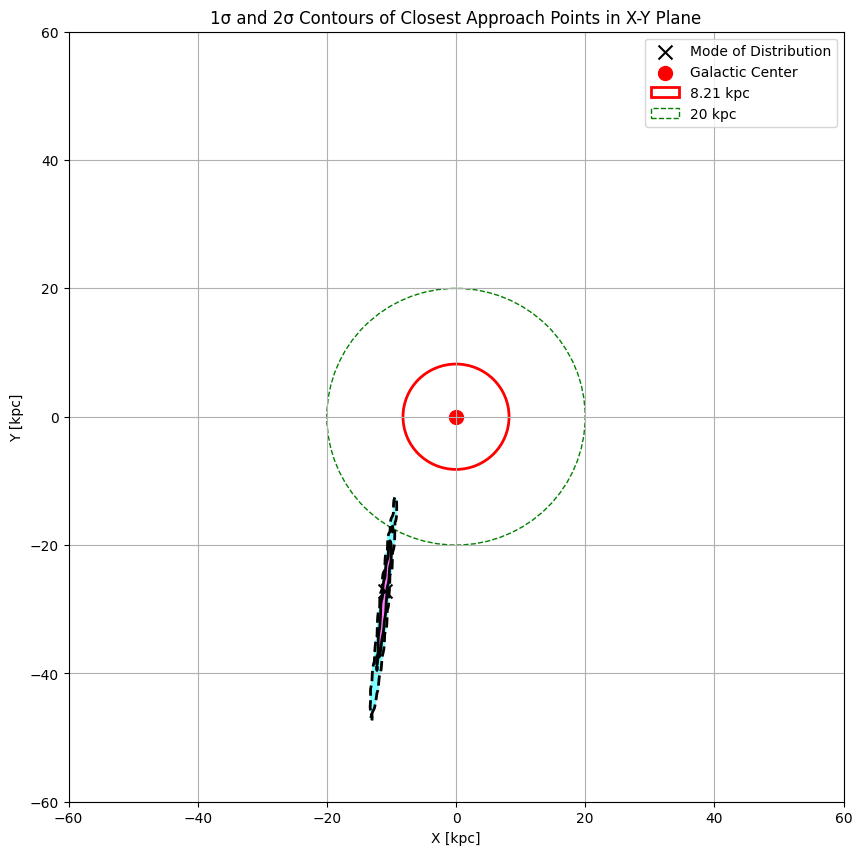

In [ ]:
hvs2_file_path = 'Data/Brown_targets/hvs2_hubblexgaia.fits'
origin_hvs_hst(hvs2_file_path)